<IPython.core.display.Javascript object>


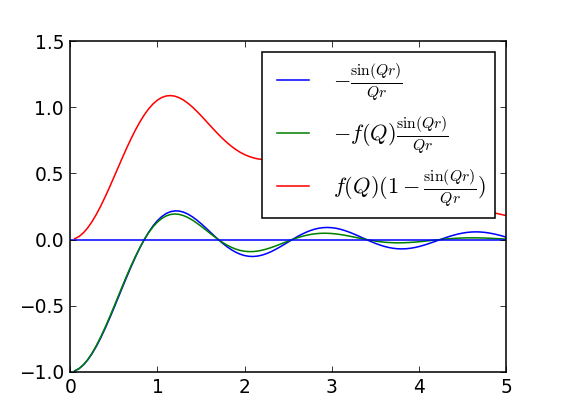

In [14]:
import numpy as np
import os
import fnmatch
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!
import matplotlib as mpl
mpl.style.use('classic')
%matplotlib notebook

def gdformfact(q):# Gd3+ form factor
    s,j,l,ss = q/(4*np.pi), 7/2., 0, 7/2. ### Take care of the fraction 9/2=4
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1))/(3*j*(j+1)+ss*(ss+1)-l*(l+1))
    
    j0 = [0.0186,25.3867,0.2895,11.1421,0.7135,3.7520,-0.0217]
    j2 = [0.3347,18.4758,1.2465,6.8767,0.9537,2.3184,0.0217]
    
    fm = (j0[0]*np.exp(-j0[1]*s**2) + j0[2]*np.exp(-j0[3]*s**2)+j0[4]*np.exp(-j0[5]*s**2) + j0[6] 
          + s**2*(j2[0]*np.exp(-j2[1]*s**2)+j2[2]*np.exp(-j2[3]*s**2)+j2[4]*np.exp(-j2[5]*s**2)+j2[6])*fc)
    return fm**2

q = np.linspace(0,5,101,endpoint=True)
r=1*np.pi
r=3.7
plt.plot(q,-np.sin(q*r)/(q*r),label=r'$-\frac{\sin(Qr)}{Qr}$')
plt.plot(q,-np.sin(q*r)/(q*r)*gdformfact(q),label=r'$-f(Q)\frac{\sin(Qr)}{Qr}$')
plt.plot(q,(1-np.sin(q*r)/(q*r))*gdformfact(q),label=r'$f(Q)(1-\frac{\sin(Qr)}{Qr})$')
plt.axhline(y=0)
plt.legend(loc='best')
plt.show()

In [16]:
################################### Read the dmc data ################
########### define the function to read ND DMC data file and the binning fun. #########
#################################################################
#%matplotlib qt
def read_dmc(fpath):
    with open(fpath, 'rU') as f:
        i, ii = 0, 0
        for line in f:     
            if i==0 or i==1:
                line = line.rstrip('\n').split()
                print "The data is",'\n',line
                i+=1
            elif i==2:          ##### Gernerate 2theta from inf. in the 3rd line
                line = line.rstrip('\n').split()
                spts,step,fpts = map(np.float,[line[0],line[1],line[2]])
                numpts = int((fpts-spts)/step+2) # why 1314 is 1313 for np
                print 'The 2theta is',spts,step,fpts,numpts
                diffdata = np.zeros((numpts,3))
                print 'The data shape is',diffdata.shape
                diffdata[:,0] = np.linspace(spts,fpts,num=numpts,endpoint=True)
                i+=1
            else:              ##### Now read the intensity and error
                if ii<numpts-1:
                    line = line.rstrip('\n').split()
                    apd = len(line)
                    diffdata[ii:ii+apd,1]= map(np.float,line)
                    ii+=apd
                else:
                    if ii<2*numpts-1:
                        line = line.rstrip('\n').split()
                        apd = len(line)
                        diffdata[ii-numpts:ii-numpts+apd,2]= map(np.float,line)
                        ii+=apd
    return diffdata

#This binning with the error calculated in this way is not good if the input data has too few point. 
# For example, if nbins=size(x), error will be 0.
def lin_binning(x,y,nbins): #input: data x,y ; No of points you want nbins  
    #nbins+=1     
    x = x[~np.isnan(x)] # remove nan from the data
    y = y[~np.isnan(y)]
    
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    meany= np.histogram(x, bins=nbins, weights=y) [0]/ n
    meany2= np.histogram(x, bins=nbins, weights=y*y)[0] / n
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return np.column_stack((meanx,meany,std_y)) #putput: nbins rows, 3 col

path='D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Gd2Zr2O7/'
data1=read_dmc(os.path.join(path,'Gd4.2_20k_2.dat'))
#print data1

In [4]:
def rmcPlot(fpath, fname, whichFit, smooth, profix, vmin,vmax):
    '''Plot the data, fit, vkt and the spinCorrel
    fpath is the folder, fname is the name of the data file without '_data.txt';
    whichFit is a nb telling which fitted curve to plot;
    smooth is [int,int] for colormap smoothing;
    profix is the profix of the vtk files'''
    ##### Data and fit#####
    datname = os.path.join(fpath,fname)# data file name without '_dat.txt'
    data = np.genfromtxt(datname+'_data.txt')#data
    # Fitted curves
    fitname= fname+'_fit_0*.txt'# fitted curves
    fnames=[] #index for different files
    for file in os.listdir(fpath):
        if fnmatch.fnmatch(file, fitname):      
            print(file)
            fnames.append(file)
    fitnameXu= fname+'_fit_xu*.txt'# fitted curves
    fnamesXu=[] #index for different files
    for file in os.listdir(fpath):
        if fnmatch.fnmatch(file, fitnameXu):      
            print(file)
            fnamesXu.append(file)

    # Plot data and fit
    fig=plt.figure(figsize=(5,4))
    plt.errorbar(data[:,0],data[:,1],data[:,2], color='black', fmt='o',markersize='6', mfc='white', label='Data')
    
    fit = np.genfromtxt(os.path.join(fpath,fnames[whichFit]), dtype=None, skip_header=1,delimiter=None)
    plt.plot(fit[:,0],fit[:,1],'red', label='Fitting')  
    #plt.plot(fit[:,0],data[1:,1]-fit[:,1],'red', label='Difference')
    if len(fnamesXu)>whichFit:
        fit = np.genfromtxt(os.path.join(fpath,fnamesXu[whichFit]), dtype=None, skip_header=1,delimiter=None)
        plt.plot(fit[:,0],fit[:,1],'blue', label='Fitting')  
    
    plt.xlabel(r"$\rm Q\ (\AA$)",size=16)
    plt.ylabel('Intensity (a.u.)',size=16)
    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    plt.legend()
    plt.show()
    
    ##### Simulated single crystal [HHL] plane #####
    try:
        vtkpath = datname+'_sc'+profix+'.vtk' #_sc.vtk'
        print vtkpath
        x, y, intensity = loadvtk(vtkpath)        
        pltmap(x, y, intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'unpolarized neutron')
        plt.show()
    except:
        pass
    try:
        vtkpath = datname+'_sc_sf'+profix+'.vtk'#'_sc_sf.vtk'
        x, y, intensity = loadvtk(vtkpath)
        pltmap(x,y,intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'SF polarized neutron')
        plt.show()
    except:
        pass        
    try:
        vtkpath = datname+'_sc_snf'+profix+'.vtk'#'_sc_snf.vtk'
        x, y, intensity = loadvtk(vtkpath)
        pltmap(x,y,intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'SNF polarized neutron')  
        plt.show()
    except:
        pass
    
    #### Plot the spin correlation function #######
    fname= datname+'_scf.txt'# fitted curves
    try:
        scf = np.genfromtxt(fname, dtype=None, skip_header=0,delimiter=None)
        fig, ax = plt.subplots(figsize=(5,4))
        rects1 = ax.bar(scf[:,0],scf[:,1], width=1, color='r')
        plt.axhline(0, color='black', lw=2)
        plt.xticks(color='k', size=14)
        plt.yticks(color='k', size=14)    
        plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
        plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
        plt.show()    
    except:
        pass
#     fig = plt.figure(figsize=(5,4))   
#     plt.plot(scf[:,0],scf[:,1],color='black',linewidth=1)
#     plt.axhline(y=0)
#     plt.minorticks_on()
#     plt.xticks(color='k', size=14)
#     plt.yticks(color='k', size=14)    
#     plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
#     plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
#     plt.show()
    

    return

def loadvtk(vtkpath):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtkpath)
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.Update()
    data = reader.GetOutput()
    dim = data.GetDimensions()
    
    d = data.GetPointData()
    array=d.GetArray('spin')
    intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')
    x = np.zeros(data.GetNumberOfPoints())
    y = np.zeros(data.GetNumberOfPoints())

    for i in range(data.GetNumberOfPoints()):
            x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded
    x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
    y = y.reshape(dim[:-1],order='F')   
    return x, y, intensity

def pltmap(x,y,intensity,smooth):#,vmin,vmax):
    # Smooth the pattern by Apply gaussian filter
    #print intensity,smooth, vmin,vmax
    import scipy as sp
    import scipy.ndimage 
    sigma_y = smooth[0]
    sigma_x = smooth[1]
    sigma = [sigma_y, sigma_x]
    Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')
    
    # only plot Instrument largest Q range
    Qlim = 4.0
    Qmod = np.sqrt(x**2+2*y**2) # why not the one: Qmod = np.sqrt(2*x**2+y**2)
    Zm = np.ma.masked_where(Qmod > Qlim, Z)

    fig = plt.figure(figsize=(5,4))
    #pcol = plt.pcolormesh(y, x, Zm, cmap='RdBu_r',vmin=vmin,vmax=vmax,linewidth=0,rasterized=True)# '_r' is reversed colormap
    pcol = plt.pcolormesh(y, x, Zm, cmap='jet',linewidth=0,rasterized=True)# '_r' is reversed colormap
    
    pcol.set_edgecolor('face') # remove the white lines in the plot
    #plt.title(fname)
    plt.axis([ -Qlim/1.414, Qlim/1.414,-Qlim, Qlim])
    plt.xlabel('(HH0)',size=14)
    plt.ylabel('(00L)',size=14)
    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    # set colorbar and its properties
    cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
    cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
    cb.ax.tick_params(labelsize=12)
    return

## DMC data plot

In [19]:
### DMC Read data: 50-20K data
fpath = r'D:\5_Neutron Scattering\2_DMC_PSI_Sep2014__NdGdZrO\Gd2Zr2O7_Refine/'
fname = r'Gd4.2_All_Data_FreeFormat.xyn'
fname = 'Gd4.2_All_Data_xy.txt'
data=np.genfromtxt(os.path.join(fpath,fname),skip_header=2)
print data.shape

#data[data==0.0]=np.nan
#data = np.ma.array (data, mask=np.isnan(data))

(1313L, 34L)


<IPython.core.display.Javascript object>


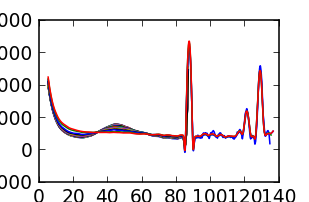

In [20]:
# Ｐｌｏｔ　２ｔｈｅｔａ，　ｓｍｏｏｔｈｅｄ
from scipy.signal import savgol_filter

plt.figure(figsize=[5,4])

for i in np.arange(0,17,1):
    mask=np.nonzero(data[:,2*i])
    x = data[mask,2*i].ravel()    
    y = data[mask,2*i+1].ravel()
    ysmooth = savgol_filter(y, 51, 3) # window size 51, polynomial order 3   
    plt.plot(x, ysmooth)
    #plt.plot(data[:,2*i],data[:,2*i+1])
    
ax=plt.gca()
# ax.set_xlim([10,85])
# ax.set_ylim([1500,5000])

plt.show()

<IPython.core.display.Javascript object>


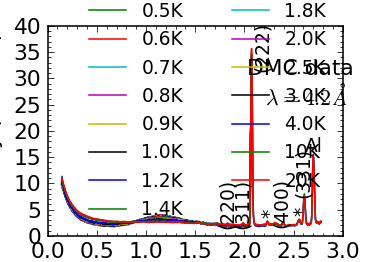

<IPython.core.display.Javascript object>


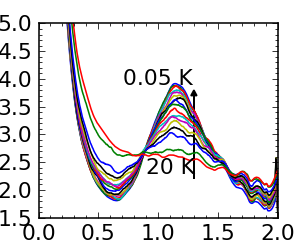

In [21]:
# Ｐｌｏｔ　Ｑ，　ｓｍｏｏｔｈｅｄ
#from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=[5,4])
#set yaxis ticklabel formate
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

wavelen = 4.2
leg = ['0.05K','0.5K','0.6K','0.7K','0.8K','0.9K','1.0K','1.2K','1.4K','1.6K','1.8K','2.0K','2.5K','3.0K','4.0K','10K','20K']
for i in np.arange(0,17,1):
    #Convert the 2theta to Astrom
    x = 4*np.pi*np.sin(data[:,2*i]/2*np.pi/180.)/4.2   
    if i==14:
        idx = np.searchsorted(x, 2, side='left', sorter=None)
        x = x[:idx].ravel()
        y = data[:idx,2*i+1].ravel()/1000 # change the unit
    else:
        mask=np.nonzero(data[:,2*i])
        x = x[mask].ravel() 
        y = data[mask,2*i+1].ravel()/1000 # change the unit
    
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    plt.plot(x, ysmooth,label=leg[i])
    #plt.plot(data[:,2*i],data[:,2*i+1])
plt.text(2.6,29,'DMC data \n $\lambda=4.2\,\AA$',size=14, ha='center', va='center',
        backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))  
plt.legend(loc=0,ncol=2,numpoints=1,frameon=False,fontsize=12).draggable()
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)

plt.ylabel(r'Intensity ($10^3$ a.u.)',size=14)
plt.xlabel(r"$\rm Q\ (\AA)$",size=14)


index =        ['(220)', '(311)', '(222)',     '*',   '(400)',     '*',   '(331)', 'Al',]#'400',
xy = np.array([[1.83,6],[1.98,6],[2.18,36],[2.26,4.2],[2.38,6.2],[2.58,4.6],[2.6,12],[2.7,17]])#[2.32,5.5],


for i in  np.arange(0,len(index),1):
    if i==len(index)-1:
        plt.text(xy[i,0],xy[i,1],index[i],size=12, ha='center', va='center',rotation=0,
            backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))  
    else:
        plt.text(xy[i,0],xy[i,1],index[i],size=12, ha='center', va='center',rotation=90,
            backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))  

fig.savefig(os.path.join(fpath,'gd_dmc_allT_0.pdf'),bbox_inches="tight",verbose=True)
plt.show()

# The zoomed figure
fig, ax = plt.subplots(figsize=[5,4])

for i in np.arange(0,17,1):
    #Convert the 2theta to Astrom
    x = 4*np.pi*np.sin(data[:,2*i]/2*np.pi/180.)/4.2   
    idx = np.searchsorted(x, 2, side='left', sorter=None)
    
    x = x[:idx].ravel()
    y = data[:idx,2*i+1].ravel()/1000 # change the unit
    
    mask=np.nonzero(x)
    x = x[mask].ravel() 
    y = y[mask].ravel()
    
#     mask=np.nonzero(data[:,2*i])    
#     x = data[mask,2*i].ravel()
#     y = data[mask,2*i+1].ravel()/1000 # change the unit

    ysmooth = savgol_filter(y, 81, 4) # window size 51, polynomial order 3  
    plt.plot(x, ysmooth)

plt.text(1.,4.0,r'0.05 K',size=14, ha='center', va='center',
        backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))    
plt.text(1.1,2.4,r'20 K',size=14, ha='center', va='center',
        backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))


plt.arrow(1.3, 2.2, 0, 1.5, head_width=0.05, head_length=0.1, fc='k', ec='k')

plt.xlim([0,2])
plt.ylim([1.5,5])
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)

plt.ylabel(r'Intensity ($10^3$ a.u.)',size=14)
plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
#fig.savefig(os.path.join(fpath,'gd_dmc_allT_1.pdf'),bbox_inches="tight",verbose=True)
plt.show()

In [33]:
#　Ｔｒｙ　ｔｏ　ｆｉｔ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ
% matplotlib notebook# in the 'notebook' mode, '@interact' gives only one fig
% matplotlib qt
from scipy.signal import savgol_filter

wavelen = 4.2
fig = plt.figure(figsize=[5,4])
for i in np.arange(0,16,1):
    mask=np.nonzero(data[:,2*i])    
    x = data[mask,2*i].ravel()
    #Convert the 2theta to Astrom
    x = 4*np.pi*np.sin(x/2*np.pi/180.)/4.2    
    y = data[mask,2*i+1].ravel()
    ysmooth = savgol_filter(y, 31, 3) # window size 51, polynomial order 3  
    plt.plot(x, ysmooth)
ax = plt.gca()

from ipywidgets import interact,FloatSlider, RadioButtons # in the 'notebook' mode, '@interact' gives only one fig
amplitude_slider1 = FloatSlider(min=1500, max=3500, step=100, value=1500)
amplitude_slider2 = FloatSlider(min=0, max=1000, step=100, value=0)

@interact(scale=amplitude_slider1, const=amplitude_slider2)
def pltc(scale,const):
    global fig, ax, fl
    try:
        fl.pop(0).remove()
    except:
        pass

    y = scale*gdformfact(x) + const    
    fl = ax.plot(x, y, 'r--')
       
    plt.xlim([0,3])
    plt.ylim([1500,5000])
    #plt.close(fig)
    return fig
    
# y = 3000*gdformfact(x) + 100   
# plt.plot(x, y, '--')


UsageError: unrecognized arguments: in the 'notebook' mode, '@interact' gives only one fig

In [34]:
interact(pltc, scale=amplitude_slider1, const=amplitude_slider2) 

NameError: name 'interact' is not defined

In [35]:
### DMC Read data: high temperature and low temperature
path='D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Gd2Zr2O7/'

data1=read_dmc(os.path.join(path,'Gd4.2_20k_2.dat'))
#print data1
data2=read_dmc(os.path.join(path,'Gd4.2_50mk.dat'))
#print data2

The data is 
['DMC,', 'Gd2Zr2O7', '4.2A', 'LD', '20k']
The data is 
['lambda=', '4.20844,', 'T=', '20.592,', 'dT=', '0.023,', "Date='2014-09-15", "06:35:40'"]
The 2theta is 5.49 0.1 136.69 1313
The data shape is (1313L, 3L)
The data is 
['DMC,', 'Gd2Zr2O7', '4.2A', 'LD', '50mk']
The data is 
['lambda=', '4.20844,', 'T=', '0.051,', 'dT=', '0.000,', "Date='2014-09-14", "02:11:21'"]
The 2theta is 5.5 0.1 136.7 1313
The data shape is (1313L, 3L)


<IPython.core.display.Javascript object>


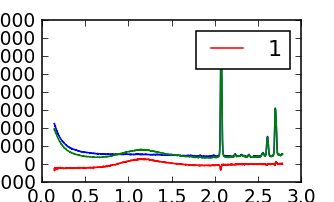

In [36]:
#DMC  Test differnt subtacted data
%matplotlib notebook
import numpy as np

#Convert the 2theta to Astrom
wavelen = 4.2
qs = 4*np.pi*np.sin(data1[:,0]/2*np.pi/180.)/4.2

fig = plt.figure(figsize=(5,4))
for i in [1]:#np.arange(0.95,1.05,0.01):
    plt.plot(qs,data1[:,1])
    plt.plot(qs,data2[:,1])
    plt.plot(qs,data2[:,1]-i*data1[:,1],label=i)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


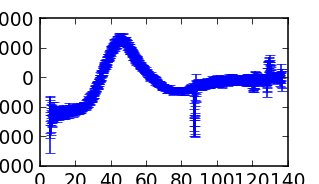

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [37]:
#DMC Plot the good subtraction
%matplotlib notebook

fig = plt.figure(figsize=(5,4))
#plt.plot(data1[:,0],data2[:,1]-data1[:,1],label=1)

subed = data2[:,1]-1*data1[:,1]

#plt.plot(data1[:,0],subed,label=0.97)
plt.legend()

# remove the data in this two ranges
selectd=np.where(~((2.05<data1[:,0])&(data1[:,0]<2.10) 
                   | ((2.68<data1[:,0])&(data1[:,0]<2.73))))
#print data1[np.logical_and(2.05<data1[:,0],data1[:,0]<2.10),0]
#print data1[selectd,0]

newd = np.vstack((data1[selectd,0],subed[selectd],2*data1[selectd,2])).T
#print newd
plt.errorbar(newd[:,0],newd[:,1],newd[:,2])
plt.show()
#np.savetxt(os.path.join(path,'gd_50mk-20k.txt'),newd, fmt='%f')

In [87]:
#DMC  clc the scale factor for SpinVert
cons = 0.07265 #in barn
s = -1000 * -3/2 / cons
print s

20646.937371


## D20 data

### Plot all the two datasets： 60mK-10K, 1.7K-20K (a scale factor ~2.8 between them)

In [41]:
# Load data and bnning
path1=r'D:\5_Neutron Scattering\3_D20_ILL_Dec2014\Reduced_Gd2Zr2O7_by_Clemens/'
path2=r'D:\5_Neutron Scattering\3_D20_ILL_Dec2014\GdZrO_short scans in cryostat/'
fname1 = ['Gd2Zr2O7_60mK.dat','Gd2Zr2O7_800mK.dat','Gd2Zr2O7_1_2K.dat','Gd2Zr2O7_10K.dat',]
fname2 = ['Gd2Zr2O7_1_7K.dat','Gd2Zr2O7_2_5K.dat','Gd2Zr2O7_5K.dat','Gd2Zr2O7_10K.dat','Gd2Zr2O7_15K.dat','Gd2Zr2O7_20K.dat']

nbins = 500
#binned = lin_binning(newd[:,0],newd[:,1],nbins)

# the first dataset
ins_zero = 0.08# instrument zero shift
wavelen = 2.41 # fix lattice 10.4415 fit wavelength
#test = np.genfromtxt(os.path.join(path1,fname1[0]), dtype=None, skip_header=6,delimiter=None)
#dataset1 = np.zeros([test.shape[0],len(fname1)*3]) 
dataset1 = np.zeros([nbins,len(fname1)*3]) 
for idx,fn in enumerate(fname1):
    temp = np.genfromtxt(os.path.join(path1,fn), dtype=None, skip_header=6,delimiter=None)
    #Convert the 2theta to Astrom
    temp[:,0] = 4*np.pi*np.sin((temp[:,0]-ins_zero)/2*np.pi/180.)/wavelen
    dataset1[:,idx*3:(idx+1)*3] = lin_binning(temp[:,0],temp[:,1],nbins)
    #dataset1[:,idx*3:(idx+1)*3] = temp

# the second dataset
ins_zero = 0.298310
wavelen =  2.402391 # fix lattice 10.4415 fit wavelength
#test = np.genfromtxt(os.path.join(path2,fname2[0]), dtype=None, skip_header=6,delimiter=None)
#dataset2 = np.zeros([test.shape[0],len(fname2)*3]) 
dataset2 = np.zeros([nbins,len(fname2)*3]) 
for idx,fn in enumerate(fname2):
    temp = np.genfromtxt(os.path.join(path2,fn), dtype=None, skip_header=6,delimiter=None)
    #Convert the 2theta to Astrom
    temp[:,0] = 4*np.pi*np.sin((temp[:,0]-ins_zero)/2*np.pi/180.)/wavelen
    dataset2[:,idx*3:(idx+1)*3] = lin_binning(temp[:,0],temp[:,1],nbins)
    #dataset2[:,idx*3:(idx+1)*3] = temp

#print dataset2
#dataset2[:,1:-1:3]= 2.54*dataset2[:,1:-1:3]# scale the two datasets
#print dataset1[:,[0,2]]


<IPython.core.display.Javascript object>


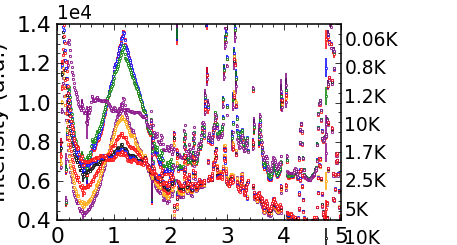

In [42]:
#plot
fig, ax = plt.subplots(figsize=[6,4])
plot_lines = []
colors =  ['red','blue','green','purple', 'orange' ]
leg1 = ['0.06K','0.8K','1.2K','10K']
for i in np.arange(0, dataset1.shape[1]/3):
    x,y,e = dataset1[:,i*3], dataset1[:,i*3+1], dataset1[:,i*3+2]
    #e[e>150] = e[e>150]*0.01
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    #plt.plot(x, ysmooth,'o',label=leg1[i])
    l = plt.errorbar(x, ysmooth, e, fmt='o',mec=colors[i],ecolor=colors[i], capsize=0, elinewidth=1,
                     mfc='white', markersize='1.5',label=leg1[i],rasterized=False)
    #l = plt.plot(x, ysmooth,c=colors[i],label=leg1[i],rasterized=False)
    plot_lines.append(l)
    
colors =  ['purple', 'orange','red','black','blue','r']
leg2 = ['1.7K','2.5K','5K','10K','15K','20K']
scale = 2.8
for i in np.arange(0, dataset2.shape[1]/3):
    x,y,e = dataset2[:,i*3], dataset2[:,i*3+1] * scale, dataset2[:,i*3+2]   
    #e[e>150] = e[e>150]*0.0005
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    #plt.plot(x, ysmooth,'o',label=leg2[i])
    l = plt.errorbar(x, ysmooth, e, fmt='o',mec=colors[i],ecolor=colors[i], capsize=0, elinewidth=1,
                     mfc='white',markersize='1.5',label=leg2[i],rasterized=False)
    #l = plt.plot(x, ysmooth,c=colors[i],label=leg2[i],rasterized=False)
    plot_lines.append(l)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#plt.legend(ncol=2,loc=0,numpoints=1,frameon=False,fontsize=12)
plt.legend(ncol=1,numpoints=1,frameon=False,fontsize=12,bbox_to_anchor=(1.26, 1.05),handlelength=1,handletextpad=0.5)
 
plt.xlim([0.0,5])
plt.ylim([4000,14000])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)

plt.ylabel(r'Intensity (a.u.)',size=14)
plt.xlabel(r"$\rm Q\ (\AA^{-1})$",size=14)


#fig.savefig(os.path.join(path1,'gd_d20_allT.pdf'),bbox_inches="tight",verbose=True)

plt.show()

<IPython.core.display.Javascript object>


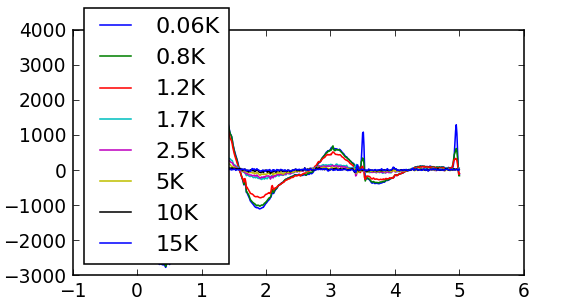

In [44]:
# Determined the subtraction factor e.g. 60mk-10K and 1.7K-20K

bkg1 = dataset1[:,-2] # the 10K data
sfact1 = np.array([0.983,0.993,0.995])# 0.995 for 600mk
leg1 = ['0.06K','0.8K','1.2K']

fig, ax = plt.subplots(figsize=[10,6])
for i in np.arange(0, dataset1.shape[1]/3-1):
    x,y,e = dataset1[:,i*3], dataset1[:,i*3+1]-sfact1[i]*bkg1, dataset1[:,i*3+2]
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    plt.plot(x, ysmooth,label=leg1[i])

bkg2 = dataset2[:,-2] # the 10K data
sfact2 = np.array([0.975,0.994,0.996,0.993,0.998])
leg2 = ['1.7K','2.5K','5K','10K','15K']
for i in np.arange(0, dataset2.shape[1]/3-1):
    x,y,e = dataset2[:,i*3], dataset2[:,i*3+1]-sfact2[i]*bkg2, dataset2[:,i*3+2]
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    plt.plot(x, ysmooth,label=leg2[i])
       
plt.legend(loc=0)    
plt.show()

In [15]:
np.arange(0,4).reshape([2,2])*[1,2]

array([[0, 2],
       [2, 6]])

In [45]:
# Remove the bad points and prepare interplate function for 10K-20K
# Do: 60mK-10K + scale 10K-20K 
# (becasue the background for the two datasets are also different)

#masking
newd = dataset1
selectd=np.where(~((newd[:,0]<0.3)|(newd[:,0]>=4.9)
                  | ((1.67<newd[:,0])&(newd[:,0]<1.69))
                  | ((2.05<newd[:,0])&(newd[:,0]<2.05))# 2.05,2.13 before
                  | ((3.3<newd[:,0])&(newd[:,0]<3.55))))
#subtraction
subed1 =dataset1
subed1[:,1:-3:3] = dataset1[:,1:-3:3]- bkg1[:,np.newaxis]*sfact1
subed1 =subed1[selectd]

#masking
subed2 =dataset2
selectd=np.where(~((newd[:,0]<0.3)|(newd[:,0]>=4.91) # insure that subed1 has smaller range than subed2 for interplatation
                  | ((1.67<newd[:,0])&(newd[:,0]<1.69))
                  | ((2.05<newd[:,0])&(newd[:,0]<2.05))# 2.05,2.13 before
                  | ((3.3<newd[:,0])&(newd[:,0]<3.55))))
#subtraction
subed2[:,1:-3:3] = dataset2[:,1:-3:3]- bkg2[:,np.newaxis]*sfact2
subed2 =subed2[selectd]

#interpolate
subed10k = interp1d(subed2[:,0],subed2[:,-8], kind='cubic')

#add back the 10K-20K signal to the first dataset
scale = 2.8 # scale factor between the two datasets
subed1[:,1:-3:3] = subed1[:,1:-3:3] + scale * subed10k(subed1[:,0])[:,np.newaxis]

<IPython.core.display.Javascript object>


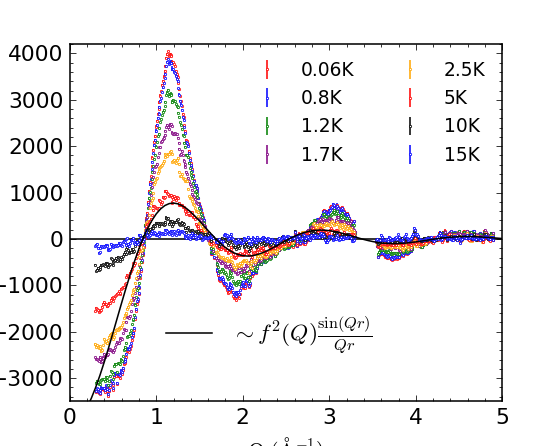

C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in divide


In [58]:
#plot
fig, ax = plt.subplots(figsize=[5,4])
plot_lines = []
colors =  ['red','blue','green','purple', 'orange' ]
leg1 = ['0.06K','0.8K','1.2K']
for i in np.arange(0, subed1.shape[1]/3-1):
    x,y,e = subed1[:,i*3], subed1[:,i*3+1], subed1[:,i*3+2]
    #e[e>150] = e[e>150]*2 # how is the subtracted data error
    e[e>50] = 20 # how is the subtracted data error
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    #plt.plot(x, ysmooth,'o',label=leg1[i])
    l = plt.errorbar(x, ysmooth, e, fmt='o',mec=colors[i],ecolor=colors[i], capsize=0, elinewidth=1,
                     mfc='white', markersize='1.5',label=leg1[i],rasterized=False)
    plot_lines.append(l)
    
colors =  ['purple', 'orange','red','black','blue' ]
leg2 = ['1.7K','2.5K','5K','10K','15K']
for i in np.arange(0, subed2.shape[1]/3-1):
    x,y,e = subed2[:,i*3], subed2[:,i*3+1] * scale, subed2[:,i*3+2]   
    e[e>50] = 20
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    #plt.plot(x, ysmooth,'o',label=leg2[i])
    l = plt.errorbar(x, ysmooth, e, fmt='o',mec=colors[i],ecolor=colors[i], capsize=0, elinewidth=1,
                     mfc='white',markersize='1.5',label=leg2[i],rasterized=False)
    plot_lines.append(l)
    
q = np.linspace(0,5,101,endpoint=True)
r=3.72
l = plt.plot(q,-4000*np.sin(q*r)/(q*r)*gdformfact(q),label=r'$\sim f^2(Q)\frac{\sin(Qr)}{Qr}$',c='black',zorder=10)
plot_lines.append(l)

# plt.text(4,-2000,r'D20 data',size=14, ha='center', va='center',
#         backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))    
plt.axhline(y=0,c='black')

# Two legends: Method 1
# first_legend = plt.legend(handles = plot_lines[0:8],numpoints=1,ncol=2,loc=0,frameon=False,fontsize=12)
# plt.gca().add_artist(first_legend)
# plt.legend(handles = plot_lines[8],numpoints=1,ncol=4,loc=[0.2,0.1],frameon=False,fontsize=12)  

# Two legends: Method 2
handles, labels = plt.gca().get_legend_handles_labels()
first_legend = plt.legend(handles[1:9],labels[1:9],ncol=2,
                           loc=0,numpoints=1,frameon=False,fontsize=12)
plt.gca().add_artist(first_legend)
plt.legend([handles[0]],[labels[0]],loc=[0.2,0.1],numpoints=1,frameon=False,fontsize=15)
 
plt.xlim([0.0,5])
plt.ylim([-3500,4200])
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)

plt.ylabel(r'Intensity (a.u.)',size=14)
plt.xlabel(r"$\rm Q\ (\AA^{-1})$",size=14)


fig.savefig(os.path.join(path1,'gd_d20_allT1.pdf'),bbox_inches="tight",verbose=True)

plt.show()


In [71]:
1.5*np.pi/3.7
10.44*1.414/4
0.5566/1.414

# 10 persons:
# Wolf, Bella, Andrew, Steve, Sharill, Katia, Alex, me, Ralf, Andre
shuCai=14.8+12.8+11.8 # V2, 12, 14: 素宫保鸡丁，笋，豆腐
Rou = 15.8+12.8+10.5 # A3 羊肉,P4 糖醋里脊，H1 宫保鸡丁
Yu = 15.8 # G3 水煮鱼
Liang = 6.8+4.8+6.8 #L3,10,17,皮蛋豆腐，五香牛肉，拍黄瓜
Jiaozi=13.8 # D1s 煎饺猪肉，大

#米饭
shuCai + Yu + Rou + Liang+ Jiaozi 
#Tang = 16 #
#Bing = 3.8*3 # N1*3 南瓜饼

# 6 persons:
# 刘，萍，辉，萧，宋敏，余： 点菜

126.50000000000001

### Process and Fit the 2nd dataset 1.7K-20K data

<IPython.core.display.Javascript object>


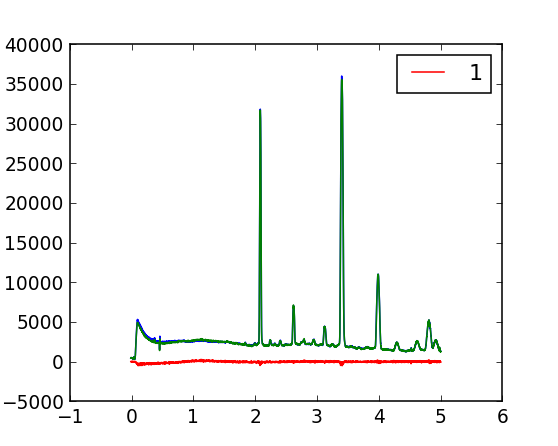

In [16]:
# Ｔｒｙ　ｆｉｔｉｎｇ　ｔｈｅ　ｓｅｃｏｎｄ　ｄａｔａｓｅｔ
#### Read the second dataset [1.7K,20K]of D20 data ################
path=r'D:\5_Neutron Scattering\3_D20_ILL_Dec2014\GdZrO_short scans in cryostat/'
fname1 = 'Gd2Zr2O7_20K.dat'
fname2 = 'Gd2Zr2O7_1_7K.dat'
fname2 = 'Gd2Zr2O7_10K.dat'

data1 = np.genfromtxt(os.path.join(path,fname1), 
                     dtype=None, skip_header=6,delimiter=None)
data2 = np.genfromtxt(os.path.join(path,fname2), 
                     dtype=None, skip_header=6,delimiter=None)
#print data1,data2

#Convert the 2theta to Astrom
ins_zero = 0.298310
wavelen = 2.402391 # fix lattice 10.4415 fit wavelength
#wavelen = 2.41# fix lattice 10.4415 fit wavelength
test       = 4*np.pi*np.sin(data1[:,0]/2*np.pi/180.)/wavelen
qs = 4*np.pi*np.sin((data1[:,0]-ins_zero)/2*np.pi/180.)/wavelen

#Test differnt subtaction
fig = plt.figure(figsize=(5,4))
for i in [1]:# np.arange(0.97,0.991,0.003):
    #plt.plot(test,data2[:,1]-0.982*data1[:,1])
    plt.plot(qs,data1[:,1])
    plt.plot(qs,data2[:,1])
    plt.plot(qs,data2[:,1]-i*data1[:,1],label=i)
plt.legend().draggable()
plt.show()

<IPython.core.display.Javascript object>


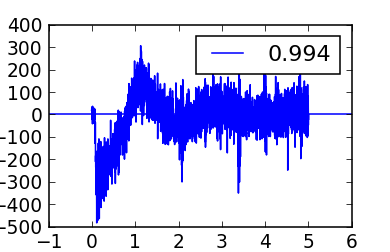

In [17]:
#Plot the good subtraction
sub_fact=0.994# for 10K, 0.975 for 1.7K
subed = data2[:,1]-sub_fact*data1[:,1]

fig = plt.figure(figsize=(5,4))
#plt.plot(qs,data2[:,1]-1.02*data1[:,1],label=1)
plt.plot(qs,subed,label=sub_fact)
plt.axhline(y=0)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


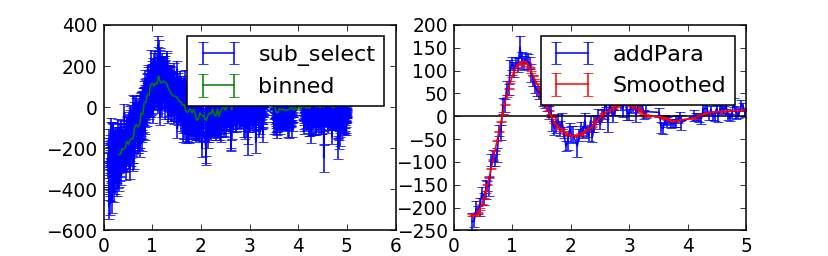

In [18]:
#Ｓｕｂｔｒａｃｔｉｏｎ　ｒｅｍｏｖｅ　ｂａｄ　ｒａｎｇｅ　ａｎｄ　ｂｉｎｎｉｎｇ
# Ｐｒｅｐａｒｅ　ｔｈｅ　ｉｎｔｅｒｐｏｌａｔｅ　ｆｕｎｃｔｉｏｎ
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
#plt.plot(data1[:,0],data2[:,1]-data1[:,1],label=1)

# Subtraction
subed = data2[:,1]-sub_fact*data1[:,1] # at first it is 8.1
#plt.plot(data1[:,0],subed,label=0.97)

# Remove the data in this two ranges
selectd=np.where(~((qs<0.1)
                   |(2.05<qs)&(qs<2.1) 
                   | ((3.3<qs)&(qs<3.5))
                   | ((3.9<qs)&(qs<4.1))))
#print selectd
newd = np.vstack((qs[selectd],subed[selectd],data1[selectd,2])).T
axs[0].errorbar(newd[:,0],newd[:,1],newd[:,2],label='sub_select')
#np.savetxt(os.path.join(path,'tho_100mk-160k.txt'),newd, fmt='%f')

# Binning
nbins = 150
binned = lin_binning(newd[:,0],newd[:,1],nbins)
#nongap = np.where(binned[:,0]!=0)# use this to select produce a deeper array
#newdd = binned[nongap,:]
newdd = binned[binned[:,0]!=0,:]

# Add the paramagnetic part
scale_factor = 0# 1250 # estimated for I(Q=0)=0 at !!!!!!!60mK!!!!!!!!!!
added = newdd[:,1] + scale_factor * gdformfact(newdd[:,0])

selectd=np.where(~((newdd[:,0]<0.3)
                   |(2.05<newdd[:,0])&(newdd[:,0]<2.1) 
                   | ((3.3<newdd[:,0])&(newdd[:,0]<3.5))
                   | ((3.9<newdd[:,0])&(newdd[:,0]<4.1))))
# print selectd
data = np.vstack((newdd[selectd,0],newdd[selectd,1],newdd[selectd,2])).T
axs[0].errorbar(data[:,0],data[:,1],data[:,2],label='binned')

data = np.vstack((newdd[selectd,0],added[selectd],newdd[selectd,2])).T
axs[1].errorbar(data[:,0],data[:,1],data[:,2],label='addPara')

dat_smooth = savgol_filter(data[:,1], 31, 3) # window size 51, polynomial order 3
axs[1].errorbar(data[:,0],dat_smooth,0.1*data[:,2], color='red',label='Smoothed')
axs[1].axhline(y=0,c='black')
axs[0].legend();axs[1].legend()
#fig.legend()
plt.show()

savepath = r'D:\9_Program files\SpinVert\gdzro_ill_2nd_1p7-20K\data_processed/'
#np.savetxt(os.path.join(savepath,'1p7K-20K_lam2p41_addP1250.txt'),data, delimiter='\t', fmt='%1.5e')
data10k = interp1d(data[:,0], dat_smooth, kind='cubic')

addPara1000_fit_01.txt
addPara1000_fit_02.txt
addPara1000_fit_03.txt
addPara1000_fit_04.txt
addPara1000_fit_05.txt


<IPython.core.display.Javascript object>


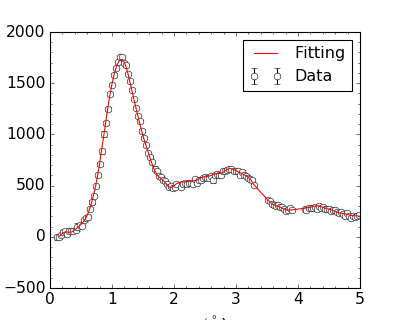

D:\9_Program files\SpinVert\gdzro_ill_2nd_1p7-20K\1p7-20k_addPara1000_lam2p41/addPara1000_sc.vtk


<IPython.core.display.Javascript object>


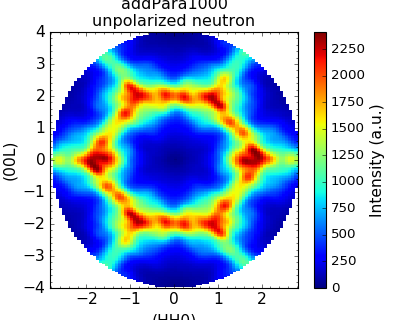

<IPython.core.display.Javascript object>


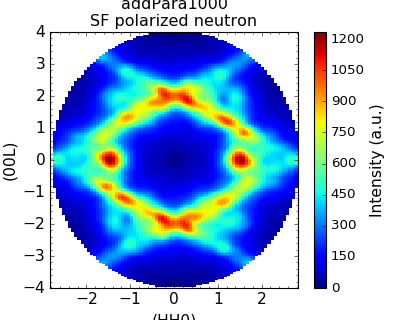

<IPython.core.display.Javascript object>


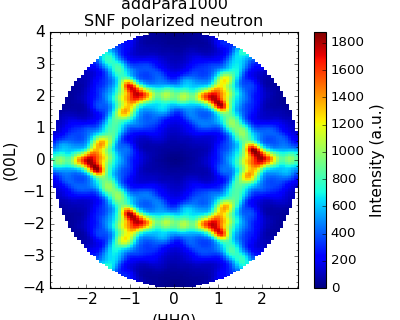

<IPython.core.display.Javascript object>


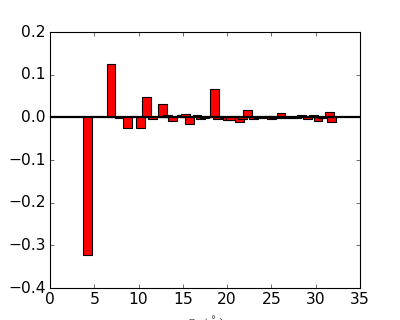

In [24]:
#　Ｐｌｏｔ　ｆｉｔｔｉｎｇ　ｒｅｓｕｌｔｓ
# Add paramag 1000 use wave length 2.41
fpath = r'D:\9_Program files\SpinVert\gdzro_ill_2nd_1p7-20K\1p7-20k_addPara1000_lam2p41/'
fname = r'addPara1000'
whichFit = 1
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

addPara1250_fit_01.txt
addPara1250_fit_02.txt


<IPython.core.display.Javascript object>


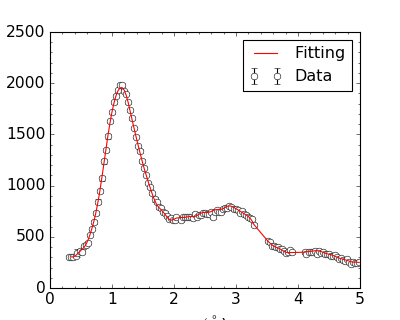

D:\9_Program files\SpinVert\gdzro_ill_2nd_1p7-20K\1p7-20k_addPara1250_lam2p41/addPara1250_sc.vtk


<IPython.core.display.Javascript object>


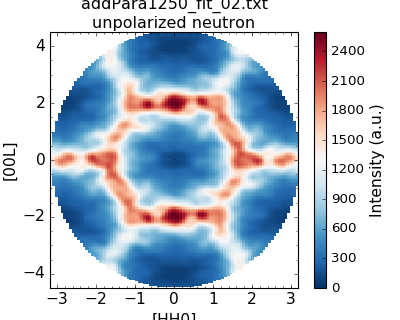

<IPython.core.display.Javascript object>


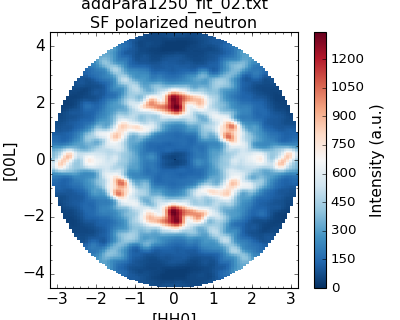

<IPython.core.display.Javascript object>


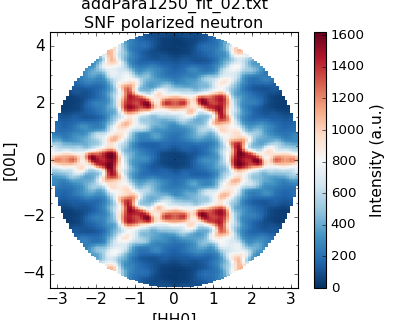

<IPython.core.display.Javascript object>


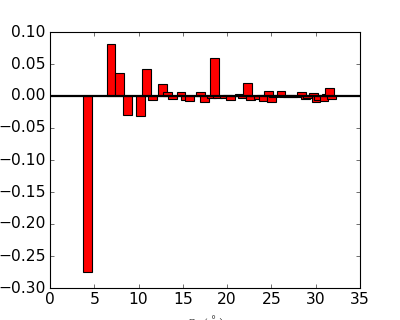

In [123]:
# Add paramag 1250 use wave length 2.41
fpath = r'D:\9_Program files\SpinVert\gdzro_ill_2nd_1p7-20K\1p7-20k_addPara1250_lam2p41/'
fname = r'addPara1250'
whichFit = 1
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

### Low temperature 60mK-10K data

<IPython.core.display.Javascript object>


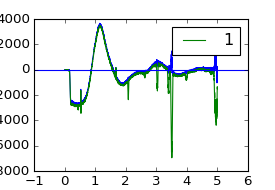

In [25]:
#### Read D20 data ################
path='D:/5_Neutron Scattering/3_D20_ILL_Dec2014/Reduced_Gd2Zr2O7_by_Clemens/'
fname1 = 'Gd2Zr2O7_10K.dat'
fname2 = 'Gd2Zr2O7_60mK.dat'
#fname2 = 'Gd2Zr2O7_1_2K.dat'

data1 = np.genfromtxt(os.path.join(path,fname1), 
                     dtype=None, skip_header=6,delimiter=None)
data2 = np.genfromtxt(os.path.join(path,fname2), 
                     dtype=None, skip_header=6,delimiter=None)
#print data1,data2

#Convert the 2theta to Astrom
ins_zero = 0.088150# instrment zero: not do included for current analysis for 60mK yet
wavelen = 2.41 # old is 2.4 now use 2.42, 2.45 for fitting the para-added data 
test       = 4*np.pi*np.sin((data1[:,0]-ins_zero)/2*np.pi/180.)/2.41
qs = 4*np.pi*np.sin((data1[:,0]-ins_zero)/2*np.pi/180.)/wavelen

#Test differnt subtaction
fig = plt.figure(figsize=(5,4))
for i in [1]:# np.arange(0.97,0.991,0.003):
    plt.plot(test,data2[:,1]-0.9835*data1[:,1])
    plt.plot(qs,data2[:,1]-i*data1[:,1],label=i)
plt.axhline(y=0)
plt.legend().draggable()
plt.show()

<IPython.core.display.Javascript object>


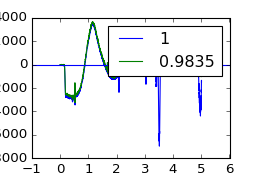

In [26]:
#Plot the good subtraction
#%matplotlib qt
sub_fact = 0.9835 # 60mK-10K: the old fitting 0.985 was used, now we use 0.9835 
#sub_fact = 0.995 # 1.2K-10K: 0.9995 was used
subed = data2[:,1]-sub_fact*data1[:,1]

fig = plt.figure(figsize=(5,4))
plt.plot(qs,data2[:,1]-data1[:,1],label=1)
plt.plot(qs,subed,label=str(sub_fact))
plt.axhline(y=0)
plt.legend()
plt.show()

(350L, 3L)


<IPython.core.display.Javascript object>


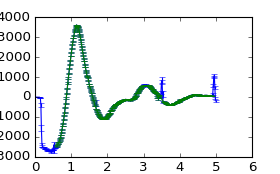

In [27]:
#### Binning data and remove bad points
#newd = np.vstack((data1[selectd,0],subed[selectd],2*data1[selectd,2])).T

# binning
newd = lin_binning(qs,subed,350)
print newd.shape

# remove the data in this two ranges: mask
selectd=np.where(~((newd[:,0]<0.6)|(newd[:,0]>4.9)
                  | ((1.67<newd[:,0])&(newd[:,0]<1.69))
                  | ((2.05<newd[:,0])&(newd[:,0]<2.05))# 2.05,2.13 before
                  | ((3.45<newd[:,0])&(newd[:,0]<3.55))
                  | ((3.01<newd[:,0])&(newd[:,0]<3.1))))

snewd = np.vstack((newd[selectd,0],newd[selectd,1],newd[selectd,2])).T

fig = plt.figure(figsize=(5,4))
plt.errorbar(newd[:,0],newd[:,1],newd[:,2])
plt.errorbar(snewd[:,0],snewd[:,1],snewd[:,2])
plt.show()
#np.savetxt(os.path.join(path,'gdill_60mk-20k.txt'),snewd, delimiter='\t', fmt='%1.5e')

In [341]:
# clc the scale factor for SpinVert
cons = 0.07265 #in barn
s = -2669 *(-3/2)/cons
s1 = 2.21*16*7*9/4*4
s2 = 2.21*16*49
s0=16*6*6*6*5
u2 = 1.5/16./np.pi**2
print s,s1,s2,s0, u2

73475.5677908 2227.68 1732.64 17280 0.00949886096647


(400L, 3L)


<IPython.core.display.Javascript object>


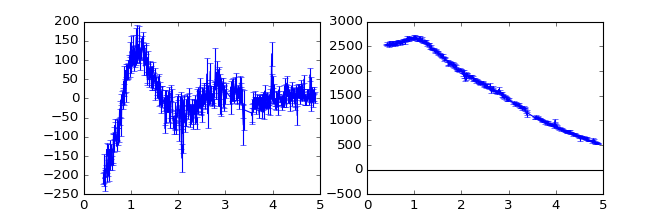

In [11]:
#Ｓｕｂｔｒａｃｔｉｏｎ,　ｒｅｍｏｖｅ　ｂａｄ　ｒａｎｇｅ　ａｎｄ　ｂｉｎｎｉｎｇ

# subtranction and binning
subed = data2[:,1]-sub_fact*data1[:,1]
newd = lin_binning(qs,subed,400)
print newd.shape

# remove the data in this two ranges: mask
# selectd=np.where(~((newd[:,0]<0.4)|(newd[:,0]>4.9) 
#                   | ((3.37<newd[:,0])&(newd[:,0]<3.6))
#                   | ((3.01<newd[:,0])&(newd[:,0]<3.1))))

selectd=np.where(~((newd[:,0]<0.4)|(newd[:,0]>4.9)# 4.8 change to 4.9 for wavelength 2.41
                  | ((1.67<newd[:,0])&(newd[:,0]<1.69))
                  | ((2.05<newd[:,0])&(newd[:,0]<2.05))#2.05,2.13 before
                  | ((3.4<newd[:,0])&(newd[:,0]<3.55))
                  | ((3.01<newd[:,0])&(newd[:,0]<3.1))))
newd = newd[selectd]

# Add the paramagnetic part and try fitting 
# Or you can further add 10K signal (in the next cells)
scale_factor = 2780 # estimated for I(Q=0)=0 of the 60mK data. For finite T, add this one also
added = newd[:,1] + scale_factor * gdformfact(newd[:,0])

# Plot
fig, axs = plt.subplots(1,2,figsize=(12,8))
axs[0].errorbar(newd[:,0],newd[:,1],newd[:,2])

axs[1].errorbar(newd[:,0],added,newd[:,2])
axs[1].set_xlim([0,5])
axs[1].axhline(y=0,color='black')
plt.show()

data = np.vstack((newd[:,0],added,newd[:,2])).T
savepath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_1p2k-20k_with_paramag/'
#np.savetxt(os.path.join(savepath,'lamda2p45_addP2780.txt'),data, delimiter='\t', fmt='%1.5e')


(400L, 3L)


<IPython.core.display.Javascript object>


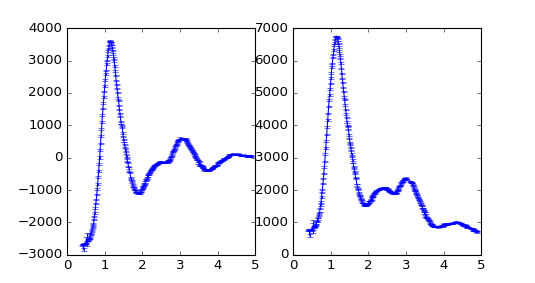

In [29]:
#Ｓｕｂｔｒａｃｔｉｏｎ,　ｌｉｎｅａｒ　ｉｎｔｅｒｐｏｌａｔｅ　ｆｏｒ　ｂａｄ　ｒａｎｇｅ　ａｎｄ　ｂｉｎｎｉｎｇ

# subtranction and binning
subed = data2[:,1]-sub_fact*data1[:,1]
newd = lin_binning(qs,subed,400)
print newd.shape

#interplate the gap region
gap=np.where((3.3<newd[:,0])&(newd[:,0]<3.55))
inter = newd[gap]

k = (inter[0,1]-inter[-1,1])/(inter[0,0]-inter[-1,0])
inter[:,1]=k * (inter[:,0]-inter[-1,0])+ inter[-1,1]

newd[gap,1]= inter[:,1]
newd[gap,2] = newd[gap,2]/2

# remove the data in this two ranges: mask
selectd=np.where(~((newd[:,0]<0.4)|(newd[:,0]>4.9)# 4.8 change to 4.9 for wavelength 2.41
                  | ((1.67<newd[:,0])&(newd[:,0]<1.69))
                  | ((3.01<newd[:,0])&(newd[:,0]<3.1))))

newd = newd[selectd]

# Add the paramagnetic part
scale_para  = 3500 # estimated for I(Q=0)=0 of the 60mK data. For finite T, add this one also
added = newd[:,1] + scale_para  * gdformfact(newd[:,0])

# Plot
fig, axs = plt.subplots(1,2,figsize=(12,8))
axs[0].errorbar(newd[:,0],newd[:,1],newd[:,2])

axs[1].errorbar(newd[:,0],added,newd[:,2])
axs[1].set_xlim([0,5])
axs[1].axhline(y=0,color='black')
plt.show()

data = np.vstack((newd[:,0],added,newd[:,2])).T
savepath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_1p2k-20k_with_paramag/'
#np.savetxt(os.path.join(savepath,'lamda2p45_addP2780.txt'),data, delimiter='\t', fmt='%1.5e')


In [1]:
1.5*3000/0.07265

61940.81211286992

<IPython.core.display.Javascript object>


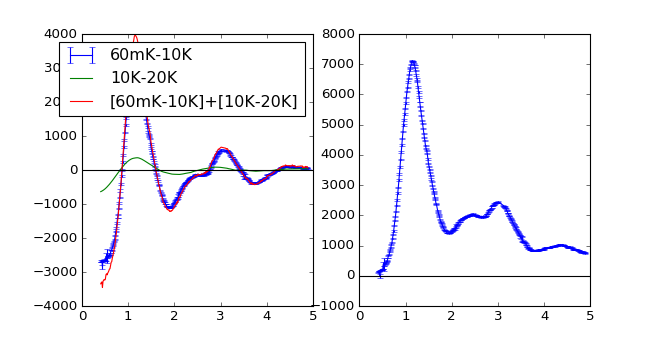

In [30]:
# add the 10K-20K signal from the 1.7-20K dataset

# Plot the 60mK-10K, 10K-20K, and addition
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].errorbar(newd[:,0],newd[:,1],newd[:,2],label='60mK-10K')

scale_10k =3 # old： 2.21/0.87 = 2.54
axs[0].errorbar(newd[:,0],scale_10k*data10k(newd[:,0]),label='10K-20K')
axs[0].errorbar(newd[:,0],scale_10k*data10k(newd[:,0])+newd[:,1],label='[60mK-10K]+[10K-20K]')
axs[0].axhline(y=0,color='black')
axs[0].legend()

# Add the paramagnetic part and plot
scale_para = 3500 # estimated for I(Q=0)=0 of the 60mK data. For finite T, add this one also
added = scale_10k*data10k(newd[:,0]) + newd[:,1] + scale_para * gdformfact(newd[:,0])

axs[1].errorbar(newd[:,0],added,newd[:,2])
axs[1].axhline(y=0,color='black')
axs[1].set_xlim([0,5])
plt.show()

# export data
data = np.vstack((newd[:,0],added,newd[:,2])).T
savepath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/'
savename = r'10k_0p994_s3_wl2p41_p3500i_data.txt'
#np.savetxt(os.path.join(savepath,savename),data, delimiter='\t', fmt='%1.5e')

# prepare file for fitting
from shutil import copyfile
#src = os.path.join(savepath,'10k_0p994_wl2p41_p3500_config.txt')
#dst = os.path.join(savepath,savename.replace('data','config'))

#copyfile(src, dst)


## Plot results

10k_0p994_s3_wl2p41_p3500i_fit_01.txt
10k_0p994_s3_wl2p41_p3500i_fit_02.txt
10k_0p994_s3_wl2p41_p3500i_fit_03.txt
10k_0p994_s3_wl2p41_p3500i_fit_04.txt
10k_0p994_s3_wl2p41_p3500i_fit_05.txt
10k_0p994_s3_wl2p41_p3500i_fit_06.txt
10k_0p994_s3_wl2p41_p3500i_fit_07.txt
10k_0p994_s3_wl2p41_p3500i_fit_08.txt
10k_0p994_s3_wl2p41_p3500i_fit_09.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu01.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu02.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu03.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu04.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu05.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu06.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu07.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu08.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu09.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu10.txt


<IPython.core.display.Javascript object>


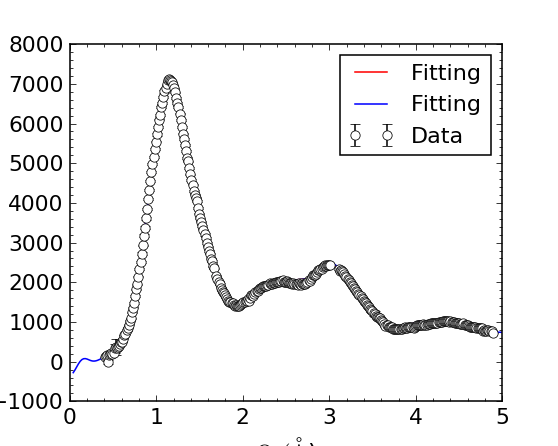

D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\programs\1st_supercell_defects/10k_0p994_s3_wl2p41_p3500i_sc.vtk


<IPython.core.display.Javascript object>


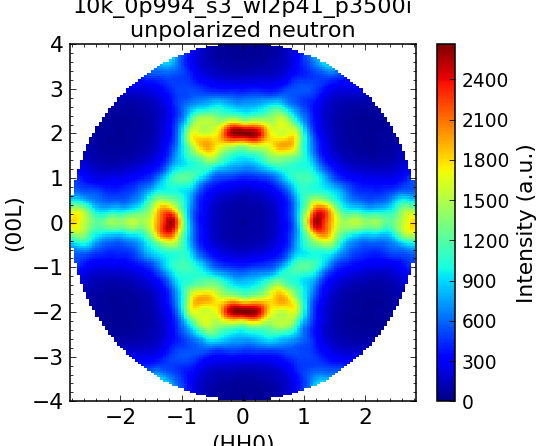

<IPython.core.display.Javascript object>


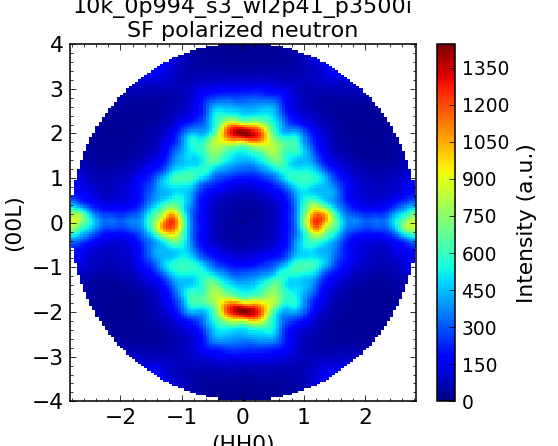

<IPython.core.display.Javascript object>


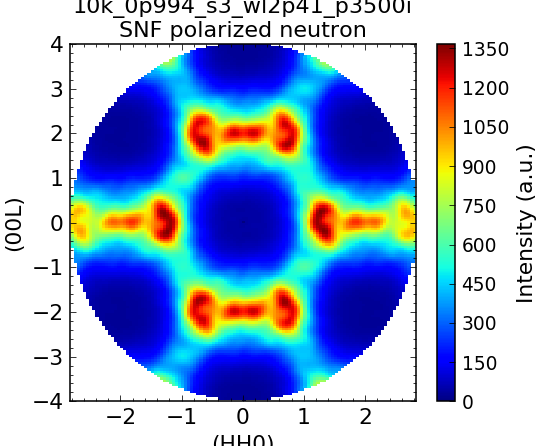

In [4]:
# 60mK - 20K(2nd dataset)
# Add paramag 3400 use wave length 2.41 
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/'
#fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag_bkg'
fpath = r'D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\programs\1st_supercell_defects/'
#fpath = r'D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\programs\2nd_supercell_defects/'
#fpath = r'D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\programs\teest_spinverxusc_on_normalSC/'
fname = r'lamda2p41_addP3400'
fname = r'10k_0p994_wl2p45_p3320'
fname = r'10k_0p994_wl2p41_p3320'
fname = r'10k_0p994_wl2p41_p3500'
fname = '10k_0p994_s3_wl2p41_p3500i'
#fname = r'10k_0p994_wl2p41_p3600'
#fname = r'10k_0p994_wl2p41_p3700'
#fname = r'10k_0p994_wl2p41_p3800'
#fname = r'10k_0p994_wl2p41_p4000'
whichFit =2
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

10k_0p994_s3_wl2p41_p3500i_fit_01.txt
10k_0p994_s3_wl2p41_p3500i_fit_02.txt
10k_0p994_s3_wl2p41_p3500i_fit_03.txt
10k_0p994_s3_wl2p41_p3500i_fit_04.txt
10k_0p994_s3_wl2p41_p3500i_fit_05.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu01.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu02.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu03.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu04.txt
10k_0p994_s3_wl2p41_p3500i_fit_xu05.txt


<IPython.core.display.Javascript object>


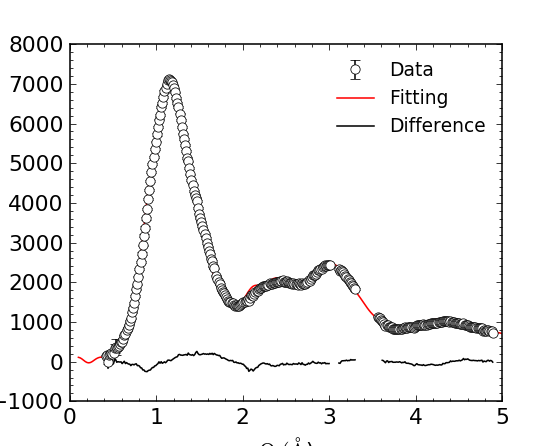

D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/10k_0p994_s3_wl2p41_p3500i_sc.vtk


<IPython.core.display.Javascript object>


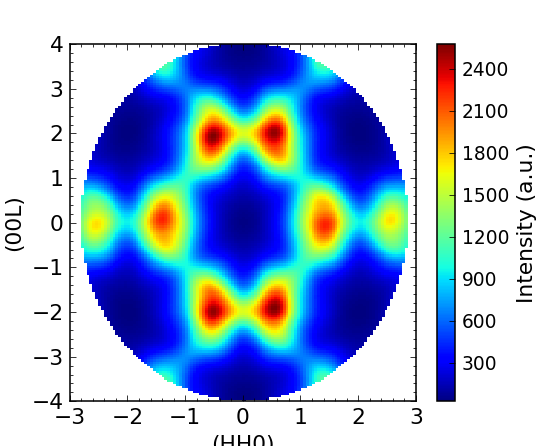

<IPython.core.display.Javascript object>


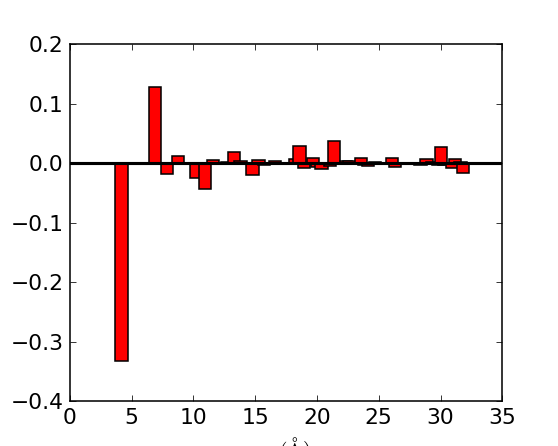

In [5]:
# Ｐｌｏｔ　ｔｈｅ　ｆｉｎａｌ　ａｃｃｅｐｔｅｄ　ｒｅｓｕｌｔ
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/' #fit with no disorder
#fpath = r'D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\programs\1st_supercell_defects/' #fit with 20% disorder
fname = '10k_0p994_s3_wl2p41_p3500i'

whichFit =0
smooth = [3,3] #[2,2] for with disorder; [3,3] for 'no disorder'

##### Data and fit#####
datname = os.path.join(fpath,fname)# data file name without '_dat.txt'
data = np.genfromtxt(datname+'_data.txt')#data
# Fitted curves
fitname= fname+'_fit_0*.txt'# fitted curves
fnames=[] #index for different files
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fitname):      
        print(file)
        fnames.append(file)
fitnameXu= fname+'_fit_xu*.txt'# fitted curves
fnamesXu=[] #index for different files
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fitnameXu):      
        print(file)
        fnamesXu.append(file)

# Plot data and fit
selectd=np.where(~((data[:,0]<0.41)|(data[:,0]>4.9)
                  | ((1.67<data[:,0])&(data[:,0]<1.69))
                  | ((2.05<data[:,0])&(data[:,0]<2.05))# 2.05,2.13 before
                  | ((3.3<data[:,0])&(data[:,0]<3.55))
                  | ((3.01<data[:,0])&(data[:,0]<3.1))))
data=data[selectd]


fig=plt.figure(figsize=(5,4))
plt.errorbar(data[:,0],data[:,1],data[:,2], color='black', fmt='o',markersize='6', mfc='white', label='Data')

if len(fnamesXu)>whichFit:
    fit = np.genfromtxt(os.path.join(fpath,fnamesXu[whichFit]), dtype=None, skip_header=1,delimiter=None)
    fm = np.ma.masked_where( fit[:,0]<0.1, fit[:,0])
    plt.plot(fm,fit[:,1],'red', label='Fitting')  

fit = np.genfromtxt(os.path.join(fpath,fnames[whichFit]), dtype=None, skip_header=1,delimiter=None)
#plt.plot(fit[:,0],fit[:,1],'red', label='Fitting')  
selectd=np.where(~((fit[:,0]<0.41)|(fit[:,0]>4.9)
                  | ((1.67<fit[:,0])&(fit[:,0]<1.69))
                  | ((2.05<fit[:,0])&(fit[:,0]<2.05))# 2.05,2.13 before
                  | ((3.3<fit[:,0])&(fit[:,0]<3.55))
                  | ((3.01<fit[:,0])&(fit[:,0]<3.1))))

fit=fit[selectd]
fm = np.ma.masked_where( ((3.0<fit[:,0])&(fit[:,0]<3.11)) |((3.38<fit[:,0])&(fit[:,0]<3.6)), fit[:,0])
plt.plot(fm,data[:,1]-fit[:,1],'black', label='Difference')

plt.xlabel(r"$\rm Q\ (\AA$)",size=14)
plt.ylabel('Intensity (a.u.)',size=14)
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)
#plt.legend(loc=0,numpoints=1,frameon=False,fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[2],handles[0],handles[1]],[labels[2],labels[0],labels[1]],
           loc=0,numpoints=1,frameon=False,fontsize=12)
#plt.savefig(os.path.join(fpath,'gd_d20_fit.pdf'),bbox_inches="tight",verbose=True)
plt.show()
    
##### Simulated single crystal [HHL] plane #####
vtkpath = datname+'_sc'+profix+'.vtk' #_sc.vtk'
print vtkpath
x, y, intensity = loadvtk(vtkpath)        
pltmap(x, y, intensity,smooth)#,vmin,vmax)
#plt.title(fname+'\n'+'unpolarized neutron')
plt.gca().set_xlim([-3,3])
plt.savefig(os.path.join(fpath,'gd_d20_simuCry.pdf'),bbox_inches="tight",verbose=True)
plt.show()

#### Plot the spin correlation function #######
fname= datname+'_scf.txt'# fitted curves

scf = np.genfromtxt(fname, dtype=None, skip_header=0,delimiter=None)
fig, ax = plt.subplots(figsize=(5,4))
rects1 = ax.bar(scf[:,0],scf[:,1], width=1, color='r')
plt.axhline(0, color='black', lw=2)
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)    
plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
plt.xlabel(r"$r\ \rm(\AA)$",size=14)
#plt.savefig(os.path.join(fpath,'gd_d20_scf.pdf'),bbox_inches="tight",verbose=True)
plt.show()    

<IPython.core.display.Javascript object>


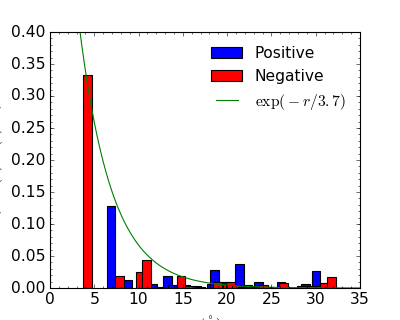

In [61]:
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/'
fname = '10k_0p994_s3_wl2p41_p3500i'
datname = os.path.join(fpath,fname)
fname= datname+'_scf.txt'# fitted curves
data = np.genfromtxt(fname, dtype=None, skip_header=0,delimiter=None)

mask1 = data[:,1] >=0
mask2 = data[:,1] < 0

from ipywidgets import interact,FloatSlider, RadioButtons
x=np.linspace(0.4,35,100)

amplitude_slider1 = FloatSlider(min=3, max=4, step=0.1, value=3.7)
amplitude_slider2 = FloatSlider(min=30, max=40, step=1, value=38)
@interact(r1=amplitude_slider1, r2=amplitude_slider2)
def pltc(r1,r2):
    fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
    #ax.plot(data[:,0],np.absolute(data[:,1]),color='black',linewidth=1)
    ax.bar(data[mask1,0],np.absolute(data[mask1,1]), width=1, color='b', label='Positive')
    ax.bar(data[mask2,0],np.absolute(data[mask2,1]), width=1, color='r', label='Negative')
    ax.plot(x,np.exp(-x/r1),label=r'$\exp{(-r/3.7)}$',c='g')
    #ax.plot(x,r2/x**3,label=r'$38/r^3$',c='black')
    ax.set_ylim(0,0.4)

    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    
    plt.ylabel(r'$|<{\bf S}(0)\cdot{\bf S}(r)>|$',size=14)
    plt.xlabel(r"$r\ \rm(\AA)$",size=14)
    
    handles, labels = ax.get_legend_handles_labels()
#     ax.legend([handles[2],handles[3],handles[0],handles[1]], 
#               [labels[2],labels[3],labels[0],labels[1]],frameon=False,framealpha=1,fontsize=14)
    ax.legend([handles[1],handles[2],handles[0]], 
              [labels[1],labels[2],labels[0]],frameon=False,framealpha=1,fontsize=14)
    
    plt.draw()

    #plt.title('New: The un-shifted data and fit')
#     fig.savefig(r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/gd_not_shifted_correl.pdf', 
#                 bbox_inches="tight",verbose=True)  
#     fig.savefig(r'D:\7_Writing\0_my_phd_thesis\Figures\gd_diffuse\gd_d20_scf.pdf', 
#                 bbox_inches="tight",verbose=True)  

addP2780_fit_01.txt
addP2780_fit_02.txt
addP2780_fit_03.txt


<IPython.core.display.Javascript object>


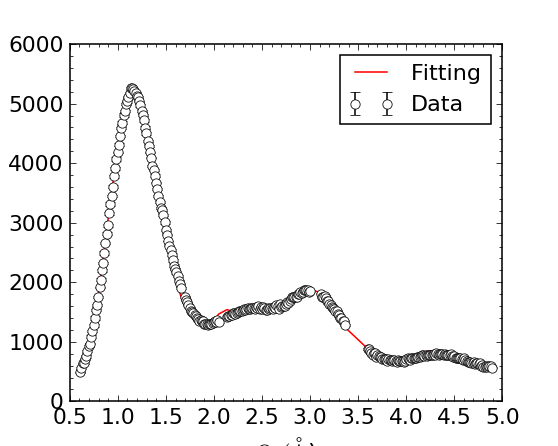

D:\9_Program files\SpinVert\gdzro_ill\gd_ill_1p2k-20k_with_paramag/addP2780_sc.vtk


<IPython.core.display.Javascript object>


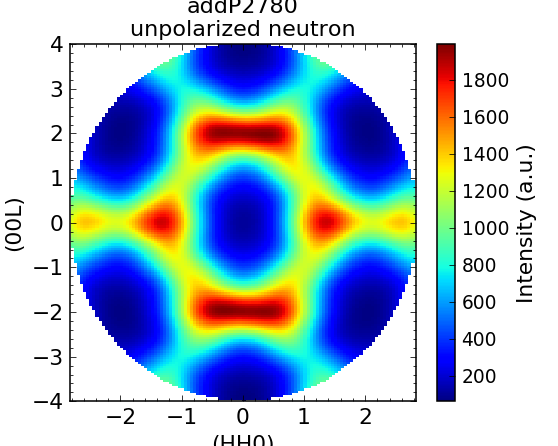

<IPython.core.display.Javascript object>


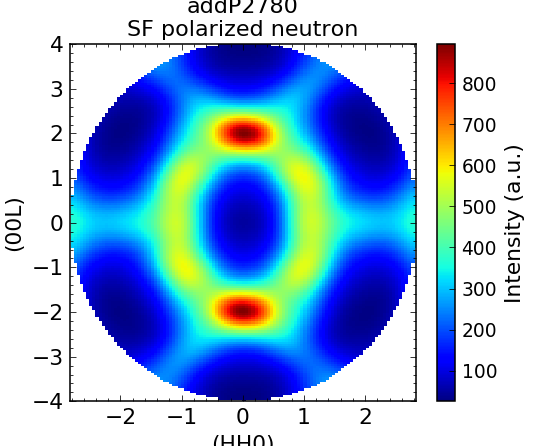

<IPython.core.display.Javascript object>


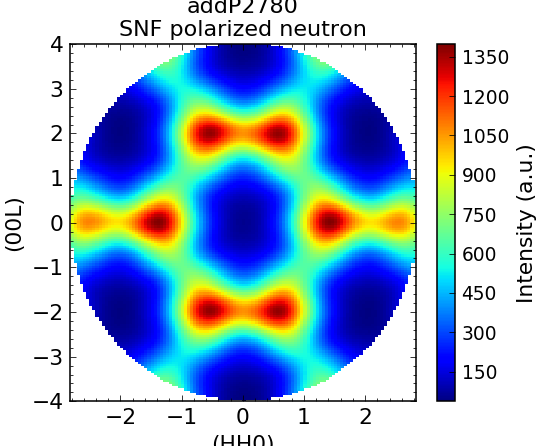

<IPython.core.display.Javascript object>


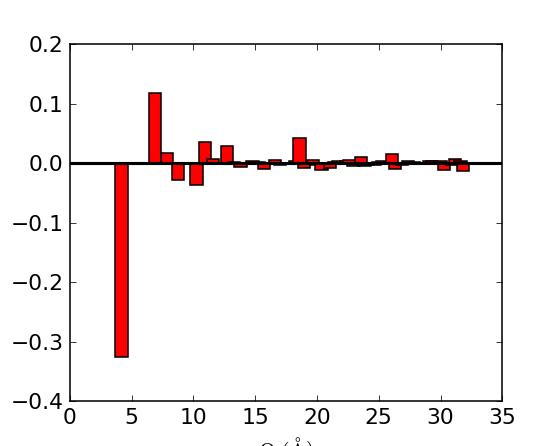

In [8]:
#  1.2K
# Add paramag 2780 use wave length 2.41 
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_1p2k-20k_with_paramag/'
fname = r'addP2780'
whichFit = 1
smoothVTK = [5,5]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

In [7]:
# Add paramag 2780 use wave length 2.4
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/'
fname = r'addP2780'
whichFit = 1
smoothVTK = [3,3]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

IOError: D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/addP2780_data.txt not found.

lamda2p42_addP2780_fit_01.txt
lamda2p42_addP2780_fit_02.txt
lamda2p42_addP2780_fit_03.txt
lamda2p42_addP2780_fit_04.txt
lamda2p42_addP2780_fit_05.txt


<IPython.core.display.Javascript object>


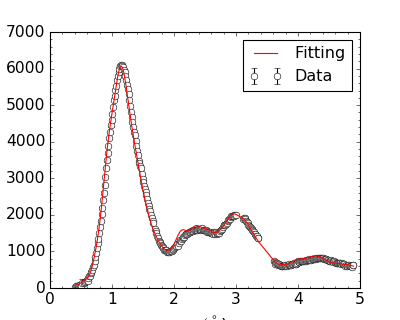

D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/lamda2p42_addP2780_sc.vtk


<IPython.core.display.Javascript object>


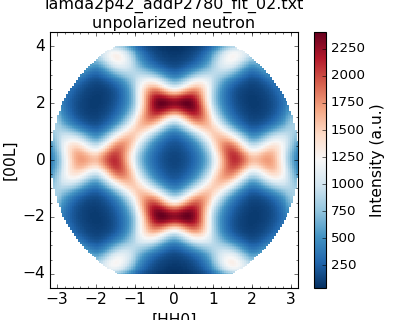

<IPython.core.display.Javascript object>


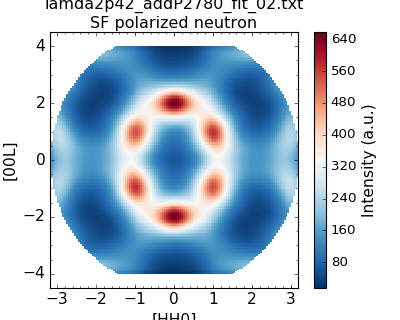

<IPython.core.display.Javascript object>


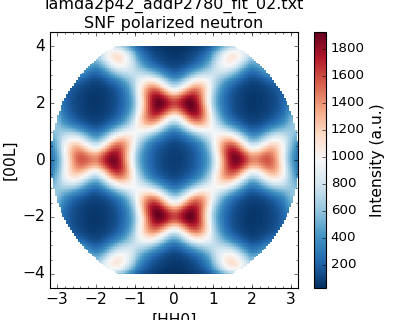

<IPython.core.display.Javascript object>


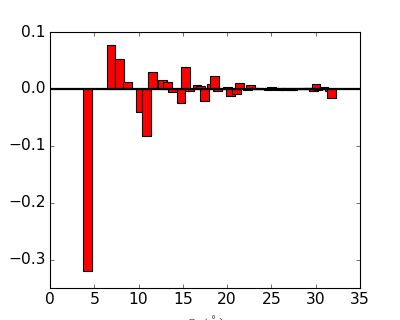

In [9]:
# Add paramag 2780 use wave length 2.42
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/'
fname = r'lamda2p42_addP2780'
whichFit = 1
smoothVTK = [5,5]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

lamda2p45_addP2780_fit_01.txt
lamda2p45_addP2780_fit_02.txt
lamda2p45_addP2780_fit_03.txt
lamda2p45_addP2780_fit_04.txt
lamda2p45_addP2780_fit_05.txt
lamda2p45_addP2780_fit_06.txt
lamda2p45_addP2780_fit_07.txt
lamda2p45_addP2780_fit_08.txt
lamda2p45_addP2780_fit_09.txt
lamda2p45_addP2780_fit_10.txt


<IPython.core.display.Javascript object>


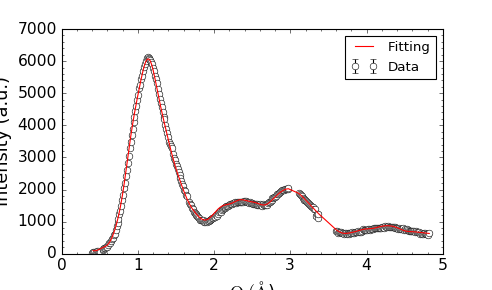

D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-10k_with_paramag/lamda2p45_addP2780_sc_222box.vtk


<IPython.core.display.Javascript object>


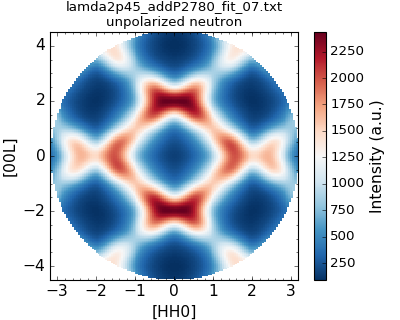

<IPython.core.display.Javascript object>


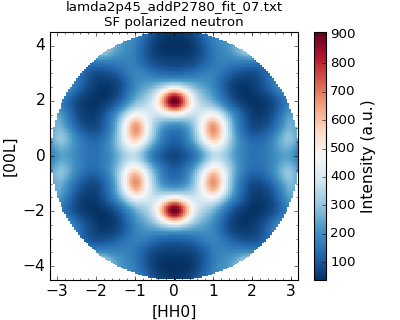

<IPython.core.display.Javascript object>


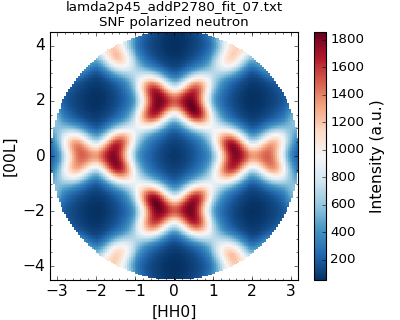

<IPython.core.display.Javascript object>


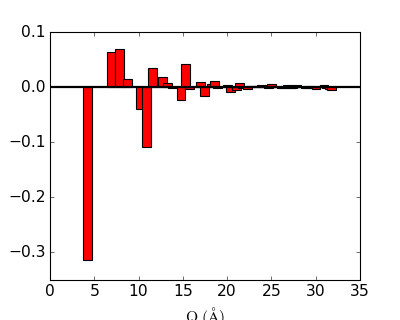

In [320]:
# Add paramag 2780 use wave length 2.45
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-10k_with_paramag/'
fname = r'lamda2p45_addP2780'
whichFit = 6
smoothVTK = [4,4]
profix =  '_222box' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

## Old analyses

gd_nshi_fprof_fit_01.txt
gd_nshi_fprof_fit_02.txt
gd_nshi_fprof_fit_03.txt
gd_nshi_fprof_fit_04.txt
gd_nshi_fprof_fit_05.txt


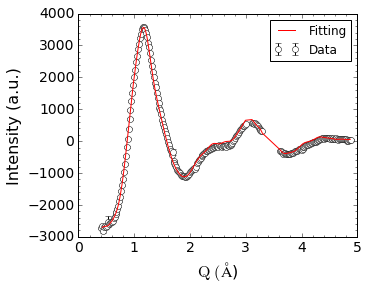

D:\9_Program files\SpinVert\gdzro_ill\fullprof/gd_nshi_fprof_sc.vtk


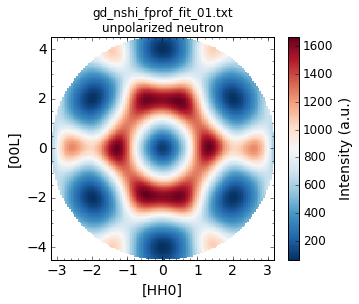

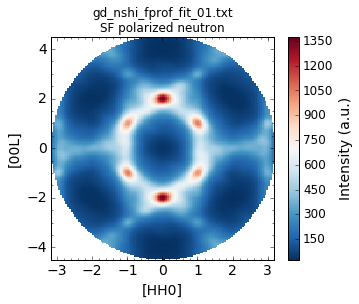

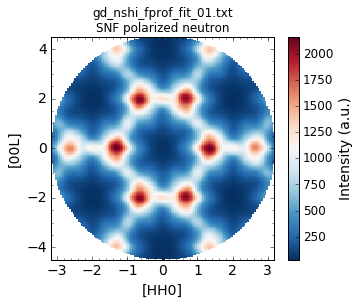

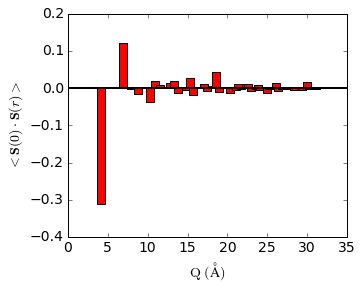

In [144]:
# Not add paramag, wave length 2.41
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\fullprof/'
fname = r'gd_nshi_fprof'
whichFit = 0
smoothVTK = [2,2]
profix =  '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

gd_not_shifted_fit_01.txt
gd_not_shifted_fit_02.txt


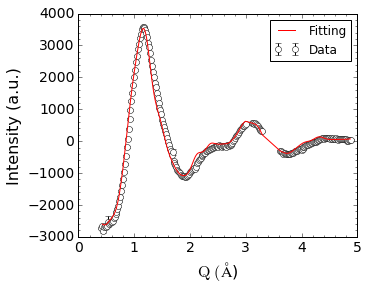

D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_without_paramag_set_scale_as_with_para/gd_not_shifted_sc.vtk


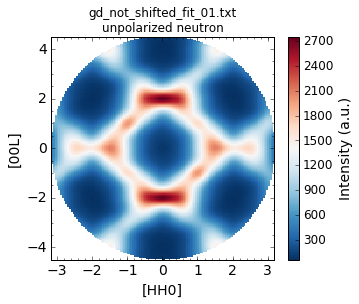

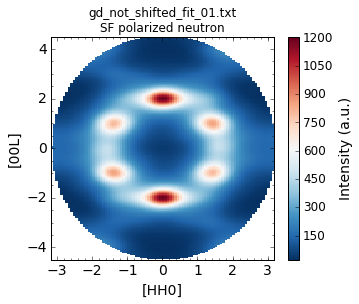

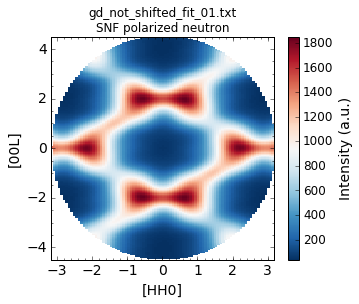

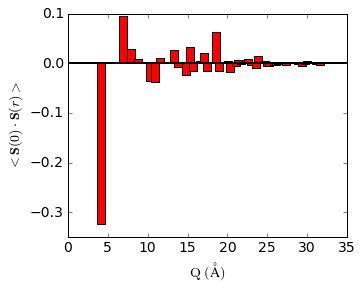

In [149]:
# Not add paramag, wave length 2.41
fpath = r'D:\9_Program files\SpinVert\gdzro_ill\gd_ill_60mk-20k_without_paramag_set_scale_as_with_para/'
fname = r'gd_not_shifted'
whichFit = 0
smoothVTK = [4,4]
profix =  '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

In [4]:
############ Plot the simulations #####################
#plot examples kagome: the vtk file produced by SPINDIFF
#%gui qt
from mayavi import mlab
path=r'D:\9_Program files\SpinVert\spinvert\spinvert\examples\kagome_afm\kagome_afm_sc.vtk'
source = mlab.pipeline.open(path)

lines = mlab.pipeline.contour_surface(source)
mlab.show()
#%gui qt
#source = mayavi.tools.pipeline.open(path) #this also work after import mayavi

ValueError: API 'QDate' has already been set to version 1

(161, 227)


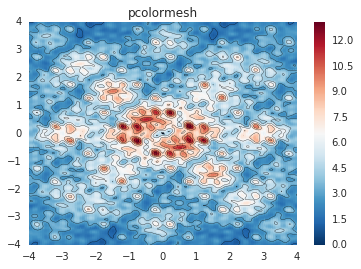

In [14]:
# load vtk and plot with Matplotlib
import vtk
from vtk.util.numpy_support import vtk_to_numpy
path=r'D:\9_Program files\SpinVert\spinvert\spinvert\examples\spinice\spinice_sc.vtk'
#path=r'D:\9_Program files\SpinVert\spinvert\spinvert\examples\kagome_afm\kagome_afm_sc.vtk'

reader = vtk.vtkDataSetReader()
reader.SetFileName(path)
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

data = reader.GetOutput()
dim = data.GetDimensions()
print dim[:-1]

d = data.GetPointData()
#array=d.GetArray('kagome_afm')#the sacalrs's name in the file
array=d.GetArray('spin')#the sacalrs's name in the file
intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')
#array = reader.GetOutput().GetPointData().GetArray("my_scalar_name")# also work
#intensity = intensity[:-1,:-1]# x and y are bounds, so intensity should be the value *inside* those bounds.
# Therefore, remove the last value from the intensity array.

x = np.zeros(data.GetNumberOfPoints())
y = np.zeros(data.GetNumberOfPoints())

for i in range(data.GetNumberOfPoints()):
        x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded

x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
y = y.reshape(dim[:-1],order='F')

# To get different color bars, reverse the plot order of conture and color plot
plt.contour(x, y, intensity, 10, colors='k',linewidths=0.3)  # negative contours will be dashed by default
plt.pcolormesh(x, y, intensity, cmap='RdBu_r')# '_r' is reversed colormap
plt.title('pcolormesh')
# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.show()


In [210]:
#plot examples spin ice
path=r'D:\9_Program files\SpinVert\spinvert\spinvert\examples\spinice\spinice_sc.vtk'
source = mlab.pipeline.open(path)
%gui qt
lines = mlab.pipeline.contour_surface(source)
mlab.show()

In [9]:
#plot our GdZrO
%gui qt
import numpy as np
from mayavi import mlab
from mayavi.modules.orientation_axes import OrientationAxes
from mayavi.modules.axes import Axes

#path='D:/Program files/SpinVert/gdzro_ill/gd_sc.vtk'
#path='D:/Program files/SpinVert/gdzro_ill/gd_not_shifted_sc.vtk'
path=r'D:\9_Program files\SpinVert\gdzro_ill\fullprof\gd_nshi_fprof_sc.vtk'
path=r'D:\9_Program files\SpinVert\spinvert\spinvert\examples\spinice\spinice_sc.vtk'
path=r'D:\9_Program files\SpinVert\gdzro_ill\fullprof\gd_nshi_fprof_sc_hk0.vtk'
path=r'D:\9_Program files\SpinVert\gdzro_ill\fullprof\gd_nshi_fprof_sc_hhk.vtk'
source = mlab.pipeline.open(path)

#mlab.figure(1, size=(500, 250), fgcolor=(1, 1, 1),bgcolor=(0.5, 0.5, 0.5))
mlab.clf()

lines = mlab.pipeline.contour_surface(source)
lines.contour.number_of_contours = 50 #change No. of conturelines
lines.contour.filled_contours = True
mlab.outline()
mlab.show()
# set two axes because mayavi not allow set nb_labels for the three axes separatly
# first axes
a0 = mlab.axes(xlabel=r"[H,H,0]",ylabel="[0,0,K]",zlabel="[1,-1,0]", z_axis_visibility = False,
               y_axis_visibility = False,ranges =np.array([-7.,  7., -4.,  4.,  0.,  0.]),nb_labels=15)
a0.axes.label_format = '%-#6.0f'
a0.label_text_property.font_size = 12
a0.label_text_property.font_family = 'arial'
a0.title_text_property.italic = False
a0.label_text_property.italic = False
a0.label_text_property.bold = True
a0.title_text_property.orientation = 90 # no effect
# second axes
e = mlab.get_engine() # get the engine
a = Axes()
a.axes.y_label="[0,0,K]"
a.axes.x_axis_visibility = False
a.axes.y_axis_visibility = False
a.axes.ranges =np.array([-7.,  7., -4.,  4.,  0.,  0.])
a.axes.number_of_labels = 9
a.axes.label_format = '%-#6.0f'
a.title_text_property.italic = False
a.label_text_property.italic = False
e.add_module(a)

# Set axes 
# f = mlab.gcf() # get the scence
# axes = f.children[0].children[0].children[2]
# axes.axes.font_factor = 1.5
# axes.axes.y_axis_visibility = False

# add module orientationAxes
e = mlab.get_engine() # get the engine
oa = OrientationAxes()
e.add_module(oa)

# add corlor bar
bar = mlab.colorbar(orientation='vertical')
b = bar.scalar_bar
b.width = 0.1
b.height = 0.8
b.position = (0.01, 0.15)     # color bar located to the left of the rendering window
b.label_text_property.color = (0,0,0)
b.title_text_property.color = (0,0,0)
b.number_of_labels = 10

#mlab.show_pipeline(rich_view=True) #open the fig editting window

(161, 161)
4.0


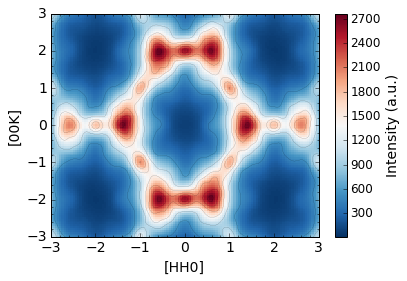

In [134]:
# load vtk and plot with Matplotlib
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy
% matplotlib inline
#fpath=r'D:\9_Program files\SpinVert\gdzro_ill\fullprof\gd_nshi_fprof_sc_hk0.vtk'
fpath=r'D:\9_Program files\SpinVert\gdzro_ill\fullprof\gd_nshi_fprof_sc_hhk.vtk'
#fpath=r'D:\9_Program files\SpinVert\gdzro_ill\fullprof\gd_nshi_fprof_sc.vtk'
reader = vtk.vtkDataSetReader()
reader.SetFileName(fpath)
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

data = reader.GetOutput()
dim = data.GetDimensions()
print dim[:-1]

d = data.GetPointData()
array=d.GetArray('spin')
intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')
#array = reader.GetOutput().GetPointData().GetArray("my_scalar_name")# also work
#intensity = intensity[:-1,:-1]# x and y are bounds, so intensity should be the value *inside* those bounds.
# Therefore, remove the last value from the intensity array.

x = np.zeros(data.GetNumberOfPoints())
y = np.zeros(data.GetNumberOfPoints())

for i in range(data.GetNumberOfPoints()):
        x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded
print np.max(x)
x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
y = y.reshape(dim[:-1],order='F')

import scipy as sp
import scipy.ndimage 
sigma_y = 2
sigma_x = 2
sigma = [sigma_y, sigma_x]
Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')

# To get different color bars, reverse the plot order of conture and color plot
fig = plt.figure()
plt.contour(y, x, intensity, 6, colors='k',linewidths=0.1)  # negative contours will be dashed by default

# pcolormesh actually draws individual rectangles which contains white lines
pcol = plt.pcolormesh(y, x, Z, cmap='RdBu_r',linewidth=0,rasterized=True)# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot
#plt.imshow(intensity, interpolation='nearest', cmap='RdBu_r', extent=[y.min(), y.max(), x.min(), x.max()])
# imshow only for uniformly spaced point

#plt.title(r'Gd$_2$Zr$_2$O$_7$')

# set the limits of the plot to the limits of the data
plt.axis([x.min()+1, x.max()-1, y.min()+1, y.max()-1])
#plt.axis([x.min(), x.max(), y.min(), y.max()])

plt.xlabel('[HH0]',size=14)
plt.ylabel('[00K]',size=14)

# plt.xlabel('[H00]',size=16)
# plt.ylabel('[0K0]',size=16)

plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)

# set colorbar and its properties
cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
#import matplotlib.font_manager
#font = matplotlib.font_manager.FontProperties(size=14)
#cb.ax.yaxis.label.set_font_properties(font)
cb.ax.tick_params(labelsize=12)

plt.show()
#fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/fullprof/scale_7p2k_hhk.pdf', bbox_inches="tight",verbose=True)  

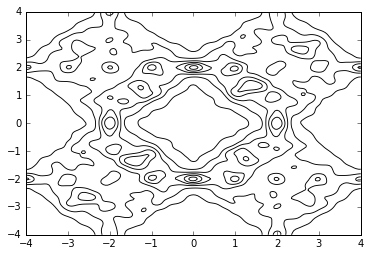

In [2]:
# only plot contour
CS = plt.contour(y, x, intensity, 6, linewidths=0.9,
                 colors='k',  # negative contours will be dashed by default
                )

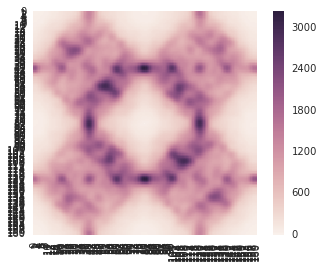

In [10]:
import seaborn as sns # After importing it, the default rc of matplotlib changes
import matplotlib.pyplot as plt
%matplotlib inline
ax = sns.heatmap(intensity, square=True)#, cmap='RdBu_r')

In [ ]:
#useless now
# set axes label manually 
Y=np.linspace(-4,4,9)
X=np.full((Y.shape), -8, dtype=np.int)
Z=np.zeros_like(Y)
textpos=np.vstack([X,Y,Z]).T
#print textpos
for x in textpos:
    t = mlab.text3d(x[0], x[1], x[2], str(x[1]), scale=0.3)    

# Example
# import scipy
# X = 100 * scipy.rand(100, 3)
# figure = mlab.figure('myfig')
# figure.scene.disable_render = True # Super duper trick
# mlab.points3d(X[:,0], X[:,1], X[:,2], scale_factor=0.4)
# for i, x in enumerate(X):
#     mlab.text3d(x[0], x[1], x[2], str(i), scale=(2, 2, 2))
# figure.scene.disable_render = False # Super duper trick

(244L, 3L)


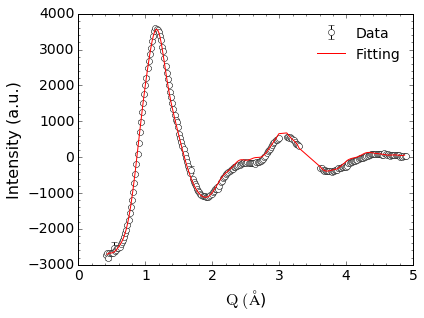

In [7]:
#Plot the data and fit GdZrO with the not-shifted data
#%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
dpath='D:/9_Program files/SpinVert/gdzro_ill/fullprof/gd_nshi_fprof_data.txt'
#dpath1='D:/Program files/SpinVert/gdzro_ill/gdill60-20k-old_data.txt'
fpath='D:/9_Program files/SpinVert/gdzro_ill/fullprof/gd_nshi_fprof_fit_01.txt'

dataf = np.genfromtxt(dpath, dtype=None, skip_header=0,delimiter=None)
print dataf.shape
#data1 = np.genfromtxt(dpath1, dtype=None, skip_header=0,delimiter=None)
fit = np.genfromtxt(fpath, dtype=None, skip_header=1,delimiter=None)
#print data

fig=plt.figure(figsize=(6,4.5))
# plt.plot(dataf[:,0],dataf[:,1],color='black',linewidth=1)
plt.errorbar(dataf[:,0],dataf[:,1],dataf[:,2], color='black', fmt='o',markersize='6', mfc='white', label='Data')
#plt.plot(data1[:,0],data1[:,1],color='red',linewidth=1)
plt.plot(fit[:,0],fit[:,1],color='red',linewidth=1, label='Fitting')

plt.xlabel(r"$\rm Q\ (\AA$)",size=16)
plt.ylabel('Intensity (a.u.)',size=16)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[1],handles[0]], [labels[1],labels[0]],loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14,fancybox=True,shadow=False)

plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)
plt.show()
# plt.title('New: The un-shifted data and fit')
#fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/fullprof/scale_7p2k_longRun.pdf', bbox_inches="tight",verbose=True)  

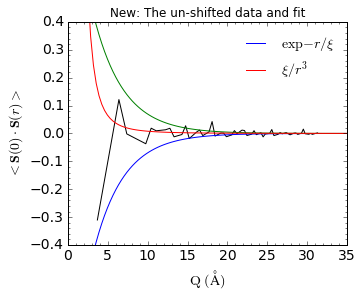

In [27]:
############### New
#Plot the Correlation functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fpath='D:/9_Program files/SpinVert/gdzro_ill/fullprof/gd_nshi_fprof_scf.txt'
data = np.genfromtxt(fpath, dtype=None, skip_header=0,delimiter=None)

from ipywidgets import interact,FloatSlider, RadioButtons
x=np.linspace(0.4,35,100)

amplitude_slider1 = FloatSlider(min=0, max=5, step=0.05, value=3)
amplitude_slider2 = FloatSlider(min=0, max=10, step=0.05, value=2.5)
@interact(r1=amplitude_slider1, r2=amplitude_slider2)
def pltc(r1,r2):
    fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
    ax.plot(data[:,0],data[:,1],color='black',linewidth=1)
    ax.plot(x,-np.exp(-x/r1),label=r'$\exp{-r/\xi}$')
    ax.plot(x,np.exp(-x/r1))
    ax.plot(x,r2/x**3,label=r'$\xi/r^3$')
    ax.set_ylim(-0.4,0.4)

    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    
    plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
    plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
    plt.legend(frameon=False,framealpha=1,fontsize=14)
    
    plt.draw()

    plt.title('New: The un-shifted data and fit')
    #fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/fullprof/gd_not_shifted_correl.pdf', bbox_inches="tight",verbose=True)  

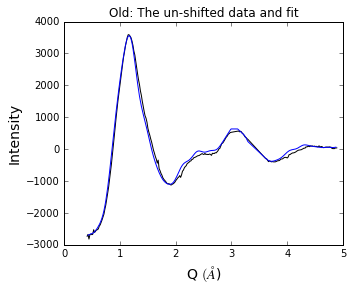

In [13]:
############### Old with different scale factor
#the same not-shifted data but with a new scale factor
#%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dpath='D:/9_Program files/SpinVert/gdzro_ill/gd_not_shifted_data.txt'
#dpath1='D:/Program files/SpinVert/gdzro_ill/gdill60-20k-old_data.txt'
#fpath1='D:/Program files/SpinVert/gdzro_ill/gd_nshi_newsc_fit_01.txt'
fpath1='D:/9_Program files/SpinVert/gdzro_ill/gd_nshi_newsc1_fit_50k.txt'
fpath2='D:/9_Program files/SpinVert/gdzro_ill/gd_nshi_newsc1_fit_60k.txt'
fpath3='D:/9_Program files/SpinVert/gdzro_ill/gd_nshi_newsc1_fit_01.txt'

dataf = np.genfromtxt(dpath, dtype=None, skip_header=0,delimiter=None)
fit1 = np.genfromtxt(fpath1, dtype=None, skip_header=1,delimiter=None)
fit2 = np.genfromtxt(fpath2, dtype=None, skip_header=1,delimiter=None)
fit3 = np.genfromtxt(fpath3, dtype=None, skip_header=1,delimiter=None)
#70000,63000,60000
fig=plt.figure(figsize=(5,4))
plt.plot(dataf[:,0],dataf[:,1],color='black',linewidth=1)
#plt.plot(fit1[:,0],fit1[:,1],linewidth=1)
#plt.plot(fit2[:,0],fit2[:,1],linewidth=1)
plt.plot(fit3[:,0],fit3[:,1],linewidth=1)
plt.ylabel('Intensity',size=14)
plt.xlabel(r"Q $(\AA$)",size=14)
plt.title('Old: The un-shifted data and fit')

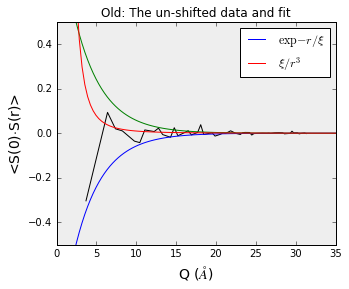

In [261]:
############### Old with different scale factor
#Plot the Correlation functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#fpath='D:/Program files/SpinVert/spinvert/spinvert/examples/spinice/spinice_scf.txt' 
#fpath='D:/Program files/SpinVert/gdzro_ill/gd_not_shifted_scf.txt'
fpath='D:/9_Program files/SpinVert/gdzro_ill/gd_nshi_newsc_scf.txt'
data = np.genfromtxt(fpath, dtype=None, skip_header=0,delimiter=None)
#print data
# fig=plt.figure(figsize=(5,4))
# ax1 =fig.add_subplot(111, autoscale_on=False, xlim=(0, 35), ylim=(-0.2, 0.1))
# ax1.plot(data[:,0],data[:,1],color='black',linewidth=1)
# plt.ylabel(r'<S(0)$\cdot$S(r)>',size=14)
# plt.xlabel(r"Q ($\AA$)",size=14)

from ipywidgets import interact,FloatSlider, RadioButtons
x=np.linspace(0.4,35,100)

amplitude_slider1 = FloatSlider(min=0, max=5, step=0.05, value=3)
amplitude_slider2 = FloatSlider(min=0, max=10, step=0.05, value=2.5)
@interact(r1=amplitude_slider1, r2=amplitude_slider2)
def pltc(r1,r2):
    fig, ax = plt.subplots(figsize=(5, 4),subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
    ax.plot(data[:,0],data[:,1],color='black',linewidth=1)
    ax.plot(x,-np.exp(-x/r1),label=r'$\exp{-r/\xi}$')
    ax.plot(x,np.exp(-x/r1))
    ax.plot(x,r2/x**3,label=r'$\xi/r^3$')
    plt.ylabel(r'<S(0)$\cdot$S(r)>',size=14)
    plt.xlabel(r"Q ($\AA$)",size=14)
    plt.legend()
    plt.draw()
    ax.set_ylim([-0.5, 0.5])
    plt.title('Old: The un-shifted data and fit')
    #fig.savefig('D:/Program files/SpinVert/gdzro_ill/gd_not_shifted_correl.eps', bbox_inches="tight",verbose=True)              

In [77]:
fig.savefig('D:/9_Program files/SpinVert/gdzro_ill/gd_not_shifted_correl.eps', bbox_inches="tight",verbose=True)  

In [134]:
#try to include subbox, failed
spcell=np.array([5,6,6])
subbox=np.array([2,3,2])
x1=np.arange(0,5,2)
x2=np.arange(0,6,3)
x3=np.arange(0,6,2)
print(x1,x2,x3)
origins=np.array(list(itertools.product(x1, x2, x3)))
#print sbcell
grid=np.mgrid[0:3,0:3,0:3]
#print grid
#print grid[0]
#print grid[1]
#print grid[2]

(array([0, 2, 4]), array([0, 3]), array([0, 2, 4]))


(256L, 3L)


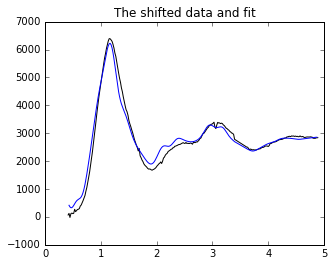

In [73]:
#Plot the #shifted# data and fit GdZrO
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dpath='D:/9_Program files/SpinVert/gdzro_ill/gd_data.txt'
#dpath1='D:/Program files/SpinVert/gdzro_ill/gdill60-20k-old_data.txt'
fpath='D:/9_Program files/SpinVert/gdzro_ill/gd_fit_05.txt'

dataf = np.genfromtxt(dpath, dtype=None, skip_header=0,delimiter=None)
print dataf.shape
#data1 = np.genfromtxt(dpath1, dtype=None, skip_header=0,delimiter=None)
fit = np.genfromtxt(fpath, dtype=None, skip_header=1,delimiter=None)
#print data

fig=plt.figure(figsize=(5,4))
plt.plot(dataf[:,0],dataf[:,1],color='black',linewidth=1)
#plt.plot(data1[:,0],data1[:,1],color='red',linewidth=1)
plt.plot(fit[:,0],fit[:,1],color='blue',linewidth=1)
plt.title('The shifted data and fit')

In [3]:
############ Now try my Fourier transforam to get neutron diff.
###############################################################
# This one only use one spin configuration file to calc.
#Below there is one use all

###read one file:read part 
import numpy as np
#fpath1='D:/Program files/SpinVert/gdzro_ill/gd_spins_01.txt'
fpath1='9_D:/Program files/SpinVert/spinvert/spinvert/examples/spinice/spinice_spins_01.txt'
spcell=np.array([6,6,6])
subbox=np.array([2,3,3])

np.linspace(0,spcell[0], num=np.floor(spcell[0]/subbox[0]), endpoint=True)
atpos=np.zeros([16,3])#store atom positons in a unit cell
allpos=np.zeros([3456,3])#store atom positons in a super cell
spins =np.zeros([3456,3])#store spins in a super cell
#read data
with open(fpath1, 'rU') as f:
    i=0
    for line in f:
        line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
        if line[0]=="SITE":
            atpos[i,:]=line[1:]#automatically convert string to np.array
            i=i+1
with open(fpath1, 'rU') as f:
    i=0        
    for line in f:        
        line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
        if line[0]=="SPIN":
            allpos[i,:]=np.array(line[2:5],dtype='f8')+atpos[int(line[1])-1,:]
            spins[i,:]=line[5:8]
            i=i+1
#type(atpos)
#atpos.dtype

IOError: [Errno 22] invalid mode ('rU') or filename: '9_D:/Program files/SpinVert/spinvert/spinvert/examples/spinice/spinice_spins_01.txt'

In [141]:
#read one file:calculat part : K points and clc.
# np.array([1,1,0]).reshape(1,3).shape
# kk=np.transpose(np.mgrid[-2:2:0.4,-2:2:0.4][1],(1,0)).reshape(100,1);
# np.concatenate((kk,kk),axis=1)
# kpts=np.linspace(-2.0, 2.0, num=41, endpoint=True)
# k110=np.repeat(kpts,41).reshape(41*41,1)
# k001=np.tile(kpts,41).reshape(41*41,1)
kpts=np.linspace(-4.0, 4.0, num=81, endpoint=True)
k110=np.repeat(kpts,81).reshape(81*81,1)
k001=np.tile(kpts,81).reshape(81*81,1)
kptss=np.concatenate((k110,k110,k001),axis=1)
#print kptss
intensity=np.sum(np.abs(np.dot(np.exp(2*np.pi*1j*np.dot(kptss,np.transpose(allpos))),spins))**2,axis=1)
#np.savetxt('D:/Program files/SpinVert/gdzro_ill/myint3.txt',
           #intensity, fmt='%f')
#save to VTK file
from tvtk.api import tvtk, write_data
sg = tvtk.StructuredPoints(dimensions=[81,81,1],
                           spacing=(0.1,0.1,0),origin=(-4,-4,0)) #two dim but means K(-4-4-4)           
sg.point_data.scalars=intensity.ravel().copy()
write_data(sg,'D:/Program files/SpinVert/gdzro_ill/mydiff1.vtk') 

In [15]:
#read one file:plot part
path='D:/9_Program files/SpinVert/gdzro_ill/mydiff1.vtk'
source = mlab.pipeline.open(path)
%gui qt
lines = mlab.pipeline.contour_surface(source)
mlab.show()

In [3]:
import numpy as np
from scipy import stats
from mayavi import mlab

mu, sigma = 0, 0.1 
x = 10*np.random.normal(mu, sigma, 5000)
y = 10*np.random.normal(mu, sigma, 5000)
z = 10*np.random.normal(mu, sigma, 5000)

xyz = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz)
density = kde(xyz)

# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.07)
mlab.axes()
mlab.show()

In [61]:
################open and read serveral files for calculation
##############################################
#for the spin ice example in SPINVERT, using a correlation cutoff is better
#because it only shows short range correlations. Otherwise niosy. 
#Ref SpinDiff manaul

import numpy as np
import fnmatch
import os

######load spin configuration files
#filepath = 'D:/9_Program files/SpinVert/gdzro_ill/'
#filename='gd_nshi_newsc_spins*.txt'
filepath = r'D:\9_Program files\SpinVert\gdzro_ill\fullprof/'
filename = 'gd_nshi_fprof_spins*.txt'
#filename = 'gd_not_shifted_spins*.txt'

filepath=r'D:\9_Program files\SpinVert\0_spinvert_program\spinvert_with_modifed\examples\spinice/'
filename='spinice_spins*.txt'

# filepath='D:/9_Program files/SpinVert/spinvert/spinvert/examples/kagome_afm/'
# filename='kagome_afm_spins_01.txt'


######Input: no. of atom per cell and supercell and no of files
natcell,spdim,TotalNfile=16,[6,6,6],5 #for Gd
natcell,spdim,nfile=16,[6,6,6],12 #for spinice
#natcell,spdim,TotalNfile=6,[10,6,10],1 #for Kagme

nfile = 1 # how manay file to read 

nat=natcell*np.prod(spdim) #total atom no.
atpos=np.zeros([natcell,3])#store the atom positions in a cell
allpos=np.zeros([nat,3])#store the atom positions in a supercell 
                        #because all the sc is of the same size we only need one varble
allspins =np.zeros([nat,3*nfile])#store the spins in a supercell for 5 runs


ii=0 #index for allspins
idx = 0
for file in os.listdir(filepath):
    if fnmatch.fnmatch(file, filename):      
        print file
        if ii==0:#get the atom positions in the 1st file
            with open(os.path.join(filepath,file), 'rU') as f:
                i=0
                for line in f:#get the atom positions in the cell
                    line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
                    if line[0]=="SITE":
                        atpos[i,:]=line[1:]#automatically convert string to np.array
                        i=i+1
            with open(os.path.join(filepath,file), 'rU') as f:
                i=0        
                for line in f:#get the atom positions in the supercell        
                    line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
                    if line[0]=="SPIN":
                        allpos[i,:]=np.array(line[2:5],dtype='f8')+atpos[int(line[1])-1,:]
                        allspins[i,ii:ii+3]=line[5:8]
                        i=i+1
            ii=ii+3        
        else:
            with open(os.path.join(filepath,file), 'rU') as f:
                i=0
                for line in f:
                    line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
                    if line[0]=="SPIN":
                        allpos[i,:]=np.array(line[2:5],dtype='f8')+atpos[int(line[1])-1,:]
                        allspins[i,ii:ii+3]=line[5:8]
                        i=i+1
            ii=ii+3
        idx = idx + 1
    if idx == nfile:
        break
print allspins
#np.savetxt(os.join(filepath,'ice_allpos.txt'), atpos, fmt='%f')
np.savetxt(os.path.join(filepath,'ice_allpos.txt'), allpos, fmt='%f')
np.savetxt(os.path.join(filepath,'ice_allspins.txt'), allspins, fmt='%f')

In [62]:
#defind K points

#for pyrochlore
k1,k2,step=-4,4,0.04#for pyrochlore
npts=int((k2-k1)/step+1)
kpts=np.linspace(k1, k2, num=npts, endpoint=True)
k110=np.repeat(kpts,npts).reshape(npts*npts,1)
k001=np.tile(kpts,npts).reshape(npts*npts,1)
kptss=np.concatenate((k001,k110,k110),axis=1)# dimension: kpts by 3

#for kageme
# k1,k2,step=-3,5,0.04#for kagome
# npts=int((k2-k1)/step+1)
# kpts=np.linspace(k1, k2, num=npts, endpoint=True)
# k100=np.tile(kpts,npts).reshape(npts*npts,1)
# k010=np.repeat(kpts,npts).reshape(npts*npts,1)
# k001=np.zeros_like(k010)
# kptss=np.concatenate((k100,k010,k001),axis=1)

from numpy import linalg as LA
#knormed=np.multiply(kptss,LA.norm(kptss,axis=1).reshape(len(kptss),1)**-1)#normalized K
knormed=kptss*LA.norm(kptss,axis=1).reshape(len(kptss),1)**-1#normalized K
knormed[np.isnan(knormed)] = 0

###calc the neutron diffuse data
#SkxSkySkz
temp = np.dot(np.exp(2*np.pi*1j*np.dot(kptss,np.transpose(allpos))),allspins) 
# ktssBy3, 3by16*ncell, 16ncellBy3*nfile ; we get kpts by 3*nfiles, that is [S1kx S1ky S1kz S2kx S2ky S2kz...] 

#(SkxSkySkz)perpendicluar
knorms=np.tile(knormed,nfile) # dim : kptss, 3*nfiles
temp = temp - (np.sum((temp*knorms).reshape((-1,3)),axis=1).reshape((-1,1))
               *knorms.reshape((-1,3))).reshape((-1,3*nfile))
print temp.shape

#(SkxSkySkz)perpendicluar
intensity=np.sum(np.real(temp*np.conj(temp)),axis=1)

#intensity=np.sum(np.real(np.multiply(temp,np.conj(temp))),axis=1)
# temp=np.dot(np.exp(2*np.pi*1j*np.dot(kptss,np.transpose(allpos))),allspins)
# d_kk=np.transpose(np.tile((1-knormed**2),nfile))
# intensity=np.sum(np.real(np.dot(temp*np.conj(temp),d_kk)),axis=1)
#tried twice before
#intensity=np.sum(np.abs(np.dot(np.exp(2*np.pi*1j*np.dot(kptss,np.transpose(allpos))),allspins))**2,axis=1)
##temp=np.dot(np.exp(2*np.pi*1j*np.dot(kptss,np.transpose(allpos))),allspins)
##intensity=np.sum(np.real(temp*np.conj(temp)),axis=1)
#np.savetxt('D:/Program files/SpinVert/gdzro_ill/myint3.txt',intensity, fmt='%f')
   
#save to VTK file
from tvtk.api import tvtk, write_data
sg = tvtk.StructuredPoints(dimensions=[npts,npts,1],
                           spacing=(step,step,0),origin=(k1,k1,0))#two dim but means K(-4-4-4)            
sg.point_data.scalars=intensity.ravel().copy()
#write_data(sg,'D:/9_Program files/SpinVert/gdzro_ill/mydiff.vtk') 
                         

In [42]:
intensity1=np.sum(np.abs(np.dot(np.exp(2*np.pi*1j*np.dot(kptss,np.transpose(allpos))),allspins))**2,axis=1)
print intensity

In [12]:
#plot 
import mayavi
from mayavi import mlab
path='D:/9_Program files/SpinVert/gdzro_ill/mydiff.vtk'
source = mlab.pipeline.open(path)
%gui qt
lines = mlab.pipeline.contour_surface(source)
mlab.show()
mlab.outline()
mlab.axes(xlabel=r"[H,H,0]",ylabel="[0,0,K]",zlabel="[1,-1,0]",
          nb_labels=4)

<IPython.core.display.Javascript object>


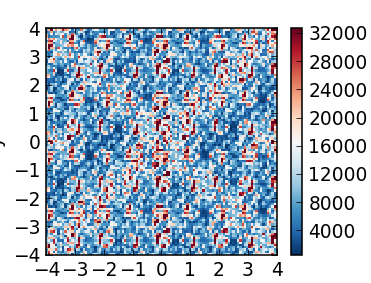

In [63]:
############
#binning the pattern clc. by me#######
k110=np.repeat(kpts,npts) #without reshape((:,1)) to remaine the shape (nL,) for histogram2d
k001=np.tile(kpts,npts)
H, xedges, yedges = np.histogram2d(k110,k001,bins=100,normed=False,weights=intensity)
#print xedges, yedges, H
#Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
 
# Plot 2D histogram using pcolor
fig = plt.figure()

plt.pcolormesh(xedges, yedges, H.T, cmap='RdBu_r',vmax=H.max()/1.5)#,vmin=np.min(H), vmax=np.max(H)-270000)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Intensity')

plt.show()

In [126]:
x1 = np.arange(9.0).reshape((3,3))
print x1
print np.exp(x1)
#np.exp
x = np.linspace(-2*np.pi, 2*np.pi, 5)
xx = x + 1j * x[:, np.newaxis] # a + ib over complex plane
out = np.exp(xx)
print out

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]]
[[  1.00000000e+00   2.71828183e+00   7.38905610e+00]
 [  2.00855369e+01   5.45981500e+01   1.48413159e+02]
 [  4.03428793e+02   1.09663316e+03   2.98095799e+03]]
[[  1.86744273e-03 +4.57391553e-19j   4.32139183e-02 +1.05843573e-17j
    1.00000000e+00 +2.44929360e-16j   2.31406926e+01 +5.66783503e-15j
    5.35491656e+02 +1.31157628e-13j]
 [ -1.86744273e-03 -2.28695776e-19j  -4.32139183e-02 -5.29217867e-18j
   -1.00000000e+00 -1.22464680e-16j  -2.31406926e+01 -2.83391752e-15j
   -5.35491656e+02 -6.55788142e-14j]
 [  1.86744273e-03 +0.00000000e+00j   4.32139183e-02 +0.00000000e+00j
    1.00000000e+00 +0.00000000e+00j   2.31406926e+01 +0.00000000e+00j
    5.35491656e+02 +0.00000000e+00j]
 [ -1.86744273e-03 +2.28695776e-19j  -4.32139183e-02 +5.29217867e-18j
   -1.00000000e+00 +1.22464680e-16j  -2.31406926e+01 +2.83391752e-15j
   -5.35491656e+02 +6.55788142e-14j]
 [  1.86744273e-03 -4.57391553e-19j   4.32139183e-02 -1.05843573e-17j
    1.0000000

gd_nshi_newsc_spins_01.txt
gd_nshi_newsc_spins_02.txt
gd_nshi_newsc_spins_03.txt
gd_nshi_newsc_spins_04.txt
gd_nshi_newsc_spins_05.txt


In [296]:
#check
print spins[4,0,0,1,1,:],spins[4,0,0,1,0,:],spins[4,0,0,1,15,:]
print poss[4,0,0,1,1,:],poss[4,0,0,1,0,:],poss[4,0,0,1,15,:]

[ 0.87810673 -0.45067084 -0.16069959] [-0.40551669 -0.12772303  0.90512046] [ 0.32860793 -0.93624302 -0.12436171]
[ 0.5  0.   1. ] [ 0.5  0.5  1.5] [ 0.25  0.25  1.5 ]


In [2]:
# defined K points
k1,k2,step=-4,4,4#for pyrochlore
npts=int((k2-k1)/step+1)
kpts=np.linspace(k1, k2, num=npts, endpoint=True)

#for pyrochlore
k110=np.repeat(kpts,npts).reshape(npts*npts,1)
k001=np.tile(kpts,npts).reshape(npts*npts,1)
kptss=np.concatenate((k001,k110,k110),axis=1).T # 3 by N
print kptss.shape,kptss.dtype

from numpy import linalg as LA
knormed=np.multiply(kptss,(LA.norm(kptss,axis=0))**-1)#normalized K
#print knormed.T
knormed[np.isnan(knormed)] = 0

#phase = np.exp(2*np.pi*1j*np.dot(poss,kptss))# poss[5666,16,3]*kpts[3,n]
#print 'phase ',phase.shape

#spinspj=np.dot(spins,knormed)

#knormed0=np.tile(knormed,natcell) # 3 by natcell*n
#spins0=np.repeat(spins,kptss.shape[1],axis=5)
#print kptss.shape[1],spins0[0,0,0,0,0,:]
#spinspj=np.dot(spins,knormed).reshape(ibox,spdim[0],spdim[1],spdim[2],1,-1)
#sperp=spins0-np.multiply(spinspj,knormed0).reshape(ibox,spdim[0],spdim[1],spdim[2],natcell,-1)
#print 'sperp ',sperp.shape

#sdk=np.dot(spins,kptss)
#sdkshape=sdk.shape
#print np.swapaxes(spins,4,5).shape
#strfct = np.dot(np.swapaxes(spins,4,5),phase) #needs a lot of RAM
# SW-spins[5,666,16,3]* exp(i2pi*(pos[5,666,16,3]*kptss[3,n]))  = 5,666,3,n : sum(ei six)... 3 by N

(3L, 9L) float64


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in reciprocal
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in multiply


In [5]:
# clc: failed
knormed0=np.tile(knormed,natcell)#parpare for 16 atoms
for i0 in np.arange(1):
# first clc the phases for all the atom in this supercell and the Sperp
# phase
    phase =np.swapaxes(np.exp(2*np.pi*1j*np.dot(poss[i0,:,:,:,:,:],kptss)),3,4)# poss[5666,16,3]*kpts[3,n]
    print 'phase ',phase.shape
    spins0=spins[i0,:,:,:,:,:]#666,16,3: copy the spins of this supercell
    print 'spins0',spins0.shape
# Sperp : repeat spin0 NO of Kpoints time for subtraction spinpjv the projection of spin to the K dirction
    spins1=np.repeat(spins0,kptss.shape[1],axis=3)#666,16n,3: COL xyz, ROW at1-nk,at16-nk
    print 'spins1',spins1.shape
    spinspj=np.dot(spins0,knormed).reshape(spdim[0],spdim[1],spdim[2],1,-1)#666,1,16n: at1-nk,at16-nk
    print 'spinpj',spinspj.shape
    spinspjv=np.multiply(spinspj,knormed0)#dim:6,6,6,1,16n * 3,16n = 666,3,16n xyzROW,at1-n,at16-n
    spinspjv1=np.swapaxes(spinspjv,3,4)
    #666,3,16n to 666,16n,3: COL xyz, ROW at1-nk,at16-nk
    print 'spinpjv',spinspjv.shape
    print 'spinpjv1',spinspjv1.shape
    sperp=np.swapaxes((spins1-spinspjv1).reshape(spdim[0],spdim[1],spdim[2],natcell,-1,3),3,4)#666，n,16,3
    print 'sperp',sperp.shape
# try to clc the intensity at one time but failed at tensordot with broadcasting the matrix    
    #m0=np.tensordot(phase,sperp,axes=([4,4]))# 666,9,16 dot 666,9,16,3
    #print m0.shape
    #conj=np.conjugate(m0)
    #print conj.shape
    #inten=np.dot(m0,np.swapaxes(np.conjugate(m0),3,4))
    #print inten.shape
    m_lot_0=np.zeros()
    m_lot_1=0.0
    m_lot_2=0.0
    m_lot_3=0.0
    for ix in np.arange(spdim[0]):
        for iy in np.arange(spdim[1]):
            for iz in np.arange(spdim[2]):
                m_lot_0=np.dot(np.swapaxes(s,4,5),phase) 

spins0 (6L, 6L, 6L, 16L, 3L)
spins1 (6L, 6L, 6L, 144L, 3L)
spinpj (6L, 6L, 6L, 1L, 144L)
spinpjv (6L, 6L, 6L, 3L, 144L)
spinpjv1 (6L, 6L, 6L, 144L, 3L)
sperp (6L, 6L, 6L, 9L, 16L, 3L)
phase  (6L, 6L, 6L, 9L, 16L)


In [232]:
k=np.array([[1,2,3],[4,5,6]]).T #K points 3*N
print k
sc=np.mgrid[0:2,0:2,0:2] #supercell 3*2*2*2, sc[:,0,1,1]==[0,1,1]
#print sc
scr=np.rollaxis(sc,0,4) #supercell 2*2*2*3, sc[0,1,1,:,]==[0,1,1]
print scr.shape,scr
print scr[1,1,1,:],np.dot([1,1,1],k),np.dot(scr[1,1,1,:],k),np.dot(scr[1,1,0,:],k)
rdotk=np.dot(scr,k) #supercell phase rdotk[0,1,1,:]==[0,1,1] dot k of 3 by N
print rdotk[1,1,1,:],rdotk[1,1,0,:]

[[1 4]
 [2 5]
 [3 6]]
(2L, 2L, 2L, 3L) [[[[0 0 0]
   [0 0 1]]

  [[0 1 0]
   [0 1 1]]]


 [[[1 0 0]
   [1 0 1]]

  [[1 1 0]
   [1 1 1]]]]
[1 1 1] [ 6 15] [ 6 15] [3 9]
[ 6 15] [3 9]


In [24]:
test=spins.reshape(ibox,spdim[0],spdim[1],spdim[2],1,-1)
print spins.shape,test.shape

(5L, 6L, 6L, 6L, 16L, 3L) (5L, 6L, 6L, 6L, 1L, 48L)


In [43]:
x1 = np.arange(16.0).reshape(4,1,4)
#print x1, '\n', x1.reshape(-1,4,1)
#print x1,x1[[1,2],:]
x2 = np.arange(12.0).reshape(3,4)
print x1,'\n',x2
print np.multiply(x1,x2)
#print x2
#np.add(x1, x2)
#x1+x2

[[[  0.   1.   2.   3.]]

 [[  4.   5.   6.   7.]]

 [[  8.   9.  10.  11.]]

 [[ 12.  13.  14.  15.]]] 
[[  0.   1.   2.   3.]
 [  4.   5.   6.   7.]
 [  8.   9.  10.  11.]]
[[[   0.    1.    4.    9.]
  [   0.    5.   12.   21.]
  [   0.    9.   20.   33.]]

 [[   0.    5.   12.   21.]
  [  16.   25.   36.   49.]
  [  32.   45.   60.   77.]]

 [[   0.    9.   20.   33.]
  [  32.   45.   60.   77.]
  [  64.   81.  100.  121.]]

 [[   0.   13.   28.   45.]
  [  48.   65.   84.  105.]
  [  96.  117.  140.  165.]]]


In [104]:
np.real(np.exp(3.14j)*2)

array(-1.999997463455079)

In [42]:
x1 = np.arange(9).reshape(3,3)
print x1
print x1**2
np.abs(np.exp(x1))**2

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[ 0  1  4]
 [ 9 16 25]
 [36 49 64]]


array([[  1.00000000e+00,   7.38905610e+00,   5.45981500e+01],
       [  4.03428793e+02,   2.98095799e+03,   2.20264658e+04],
       [  1.62754791e+05,   1.20260428e+06,   8.88611052e+06]])

In [6]:
import itertools
import numpy as np
permu=list(itertools.product([0,1,-1], repeat=3))
#print permu,type(permu)
permu=np.array(permu)
print permu
#print idx
#print x1[[1,1]]#get two rows
#print x1[(1,1)]#get the element
# x2=np.array([[0,0],[0,1],[5,1],[0,4]])
# print x2[np.where(x2[:,0:2]==np.array([0,0]))]
# print x2[x2[:,0:2]==np.array([0,1])]
# #print x2[:,0:2]
# out=np.where(np.any(x2>=np.array([2,3]),axis=1))#compare row and returen the row index
# out
# print x2[out]


In [95]:
#print list(itertools.product([0,2,4], [0,3],[0,2]))
sbcell=np.array(list(itertools.product([1,2], [2,3,4],[0,1,2])))
print sbcell
np.where(np.all(sbcell>np.array([2,2,]),axis=1))
print np.remainder(np.split([4,7,2,2],2),[2,3])

AttributeError: 'list' object has no attribute 'shape'

In [143]:
b = np.array([[1, 2], [3, 4]])
np.tile(b, 2)
1-b

array([[ 0, -1],
       [-2, -3]])